In [1]:
!pip -q install xgboost imbalanced-learn

---
### **Imports**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve, f1_score, precision_score, recall_score
)

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

---
## **Data Loading and Exploration**



In [4]:
df = pd.read_csv("/content/BankChurners.csv")
print(f"Dataset shape: {df.shape}")

Dataset shape: (10127, 23)


In [5]:
print(f"Columns: {list(df.columns)}")
print(f"Memory usage: {df.memory_usage().sum() / 1024**2:.2f} MB")

Columns: ['CLIENTNUM', 'Attrition_Flag', 'Customer_Age', 'Gender', 'Dependent_count', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2']
Memory usage: 1.78 MB


In [6]:
# Drop the two trailing helper columns & the ID
df = df.iloc[:, :-2].copy()
df = df.drop(columns=["CLIENTNUM"], errors="ignore")

In [7]:
df.head()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [8]:
df['Churn'] = df['Attrition_Flag'].map({
    'Attrited Customer': 1,
    'Existing Customer': 0
})

In [9]:
print("\n📋 Dataset Info:")
print(df.info())


📋 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Attrition_Flag            10127 non-null  object 
 1   Customer_Age              10127 non-null  int64  
 2   Gender                    10127 non-null  object 
 3   Dependent_count           10127 non-null  int64  
 4   Education_Level           10127 non-null  object 
 5   Marital_Status            10127 non-null  object 
 6   Income_Category           10127 non-null  object 
 7   Card_Category             10127 non-null  object 
 8   Months_on_book            10127 non-null  int64  
 9   Total_Relationship_Count  10127 non-null  int64  
 10  Months_Inactive_12_mon    10127 non-null  int64  
 11  Contacts_Count_12_mon     10127 non-null  int64  
 12  Credit_Limit              10127 non-null  float64
 13  Total_Revolving_Bal       10127 non-null  in

In [10]:
print("🔍 Unique values for Category columns Analysis:")
print(df.select_dtypes(include="object").nunique())

🔍 Unique values for Category columns Analysis:
Attrition_Flag     2
Gender             2
Education_Level    7
Marital_Status     4
Income_Category    6
Card_Category      4
dtype: int64


In [11]:
print("🔍 Unique values for Numerical columns Analysis:")
print(df.select_dtypes(exclude="object").nunique())

🔍 Unique values for Numerical columns Analysis:
Customer_Age                  45
Dependent_count                6
Months_on_book                44
Total_Relationship_Count       6
Months_Inactive_12_mon         7
Contacts_Count_12_mon          7
Credit_Limit                6205
Total_Revolving_Bal         1974
Avg_Open_To_Buy             6813
Total_Amt_Chng_Q4_Q1        1158
Total_Trans_Amt             5033
Total_Trans_Ct               126
Total_Ct_Chng_Q4_Q1          830
Avg_Utilization_Ratio        964
Churn                          2
dtype: int64


In [12]:
print("🔍 Missing Values Analysis:")
missing_values = df.isnull().sum()
print(missing_values)

🔍 Missing Values Analysis:
Attrition_Flag              0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
Churn                       0
dtype: int64


In [13]:
print("🔍 Duplicated Values Analysis:")
print(df.duplicated().sum())

🔍 Duplicated Values Analysis:
0


In [14]:
print("\n📊 Statistical Summary:")
df.describe()


📊 Statistical Summary:


,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Churn
count,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,46.325960,2.346203,35.928409,3.812580,2.341167,2.455317,8631.953698,1162.814061,7469.139637,0.759941,4404.086304,64.858695,0.712222,0.274894,0.160660
std,8.016814,1.298908,7.986416,1.554408,1.010622,1.106225,9088.776650,814.987335,9090.685324,0.219207,3397.129254,23.472570,0.238086,0.275691,0.367235
min,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000,0.000000,0.000000,0.000000
25%,41.000000,1.000000,31.000000,3.000000,2.000000,2.000000,2555.000000,359.000000,1324.500000,0.631000,2155.500000,45.000000,0.582000,0.023000,0.000000
50%,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000,4549.000000,1276.000000,3474.000000,0.736000,3899.000000,67.000000,0.702000,0.176000,0.000000
75%,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000,11067.500000,1784.000000,9859.000000,0.859000,4741.000000,81.000000,0.818000,0.503000,0.000000
max,73.000000,5.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,2517.000000,34516.000000,3.397000,18484.000000,139.000000,3.714000,0.999000,1.000000


In [15]:
print("\n📊 Target Variable Distribution:")
target_counts = df['Attrition_Flag'].value_counts()
print(target_counts)
churn_rate = target_counts['Attrited Customer'] / len(df) * 100
print(f"Churn Rate: {churn_rate:.2f}%")
print(f"Imbalance Ratio: {target_counts['Existing Customer'] / target_counts['Attrited Customer']:.2f}:1")


📊 Target Variable Distribution:
Attrition_Flag
Existing Customer    8500
Attrited Customer    1627
Name: count, dtype: int64
Churn Rate: 16.07%
Imbalance Ratio: 5.22:1


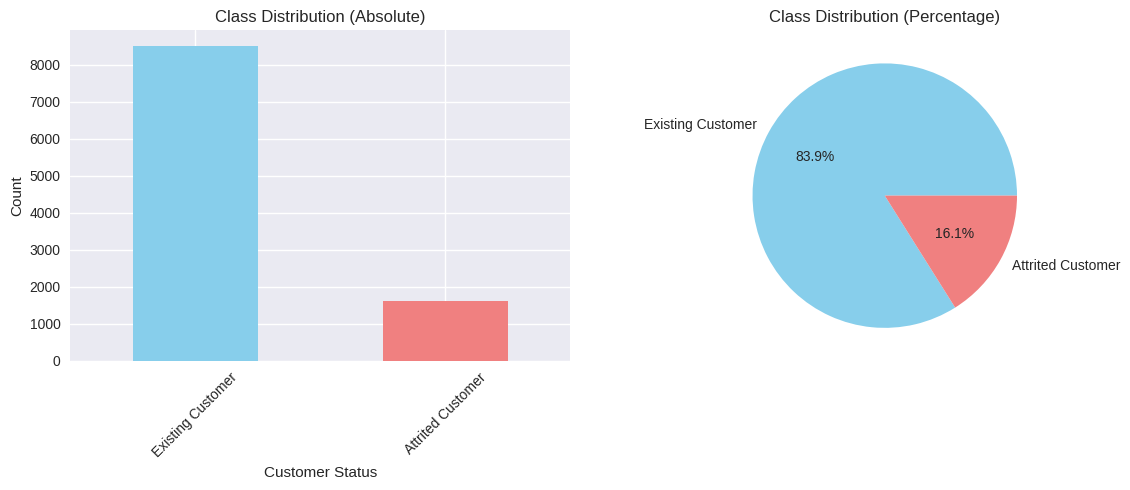

In [16]:
# Visualize class imbalance
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
target_counts.plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('Class Distribution (Absolute)')
plt.xlabel('Customer Status')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.pie(target_counts.values, labels=target_counts.index, autopct='%1.1f%%',
        colors=['skyblue', 'lightcoral'])
plt.title('Class Distribution (Percentage)')

plt.tight_layout()
plt.show()

The dataset is imbalanced, with the vast majority of customers being retained. Since only about 1 in 6 customers churn, predictive models may become biased toward predicting "retained." Handling this imbalance (e.g., via resampling or class weights) will be crucial for accurate churn prediction.

In [17]:
categorical_cols = df.select_dtypes(include='object').columns.tolist()
categorical_cols.remove('Attrition_Flag') # Exclude Attrition_Flag since it was used to create Churn

In [18]:
print("\n--- Handling 'Unknown' Values in Categorical Features ---")

unknown_counts = {}
for col in categorical_cols:
    count = df[col].isin(['Unknown', 'Unk', 'None', 'Null', 'NA']).sum()
    if count > 0:
        unknown_counts[col] = count

print("Count of 'Unknown' or 'Unk' values in Categorical Columns:")
for k, v in unknown_counts.items():
    print(f"- {k}: {v} samples ({v/len(df):.2%})")


--- Handling 'Unknown' Values in Categorical Features ---
Count of 'Unknown' or 'Unk' values in Categorical Columns:
- Education_Level: 1519 samples (15.00%)
- Marital_Status: 749 samples (7.40%)
- Income_Category: 1112 samples (10.98%)


---
## **Exploratory Data Analysis (EDA)**

### **--- Customer Demographics**

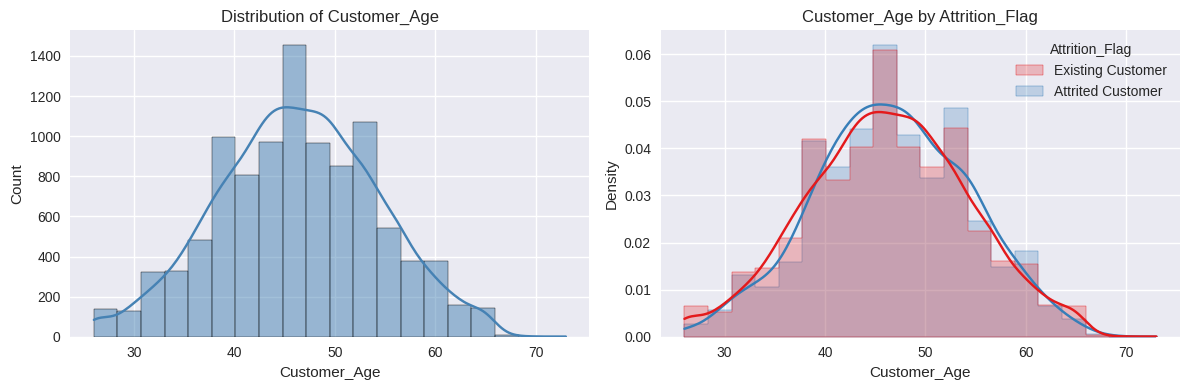

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Histogram
sns.histplot(df['Customer_Age'], kde=True, bins=20, ax=axes[0], color="steelblue")
axes[0].set_title("Distribution of Customer_Age")
axes[0].set_xlabel('Customer_Age')
axes[0].set_ylabel("Count")

# Distribution by Attrition
sns.histplot(data=df, x='Customer_Age', hue="Attrition_Flag", kde=True, bins=20, ax=axes[1],
            palette="Set1", element="step", stat="density", common_norm=False)
axes[1].set_title("Customer_Age by Attrition_Flag")
axes[1].set_xlabel('Customer_Age')
axes[1].set_ylabel("Density")

plt.tight_layout()
plt.show()

In [ ]:
print(df['Income_Category'].unique())

['$60K - $80K' 'Less than $40K' '$80K - $120K' '$40K - $60K' '$120K +'
 'Unknown']


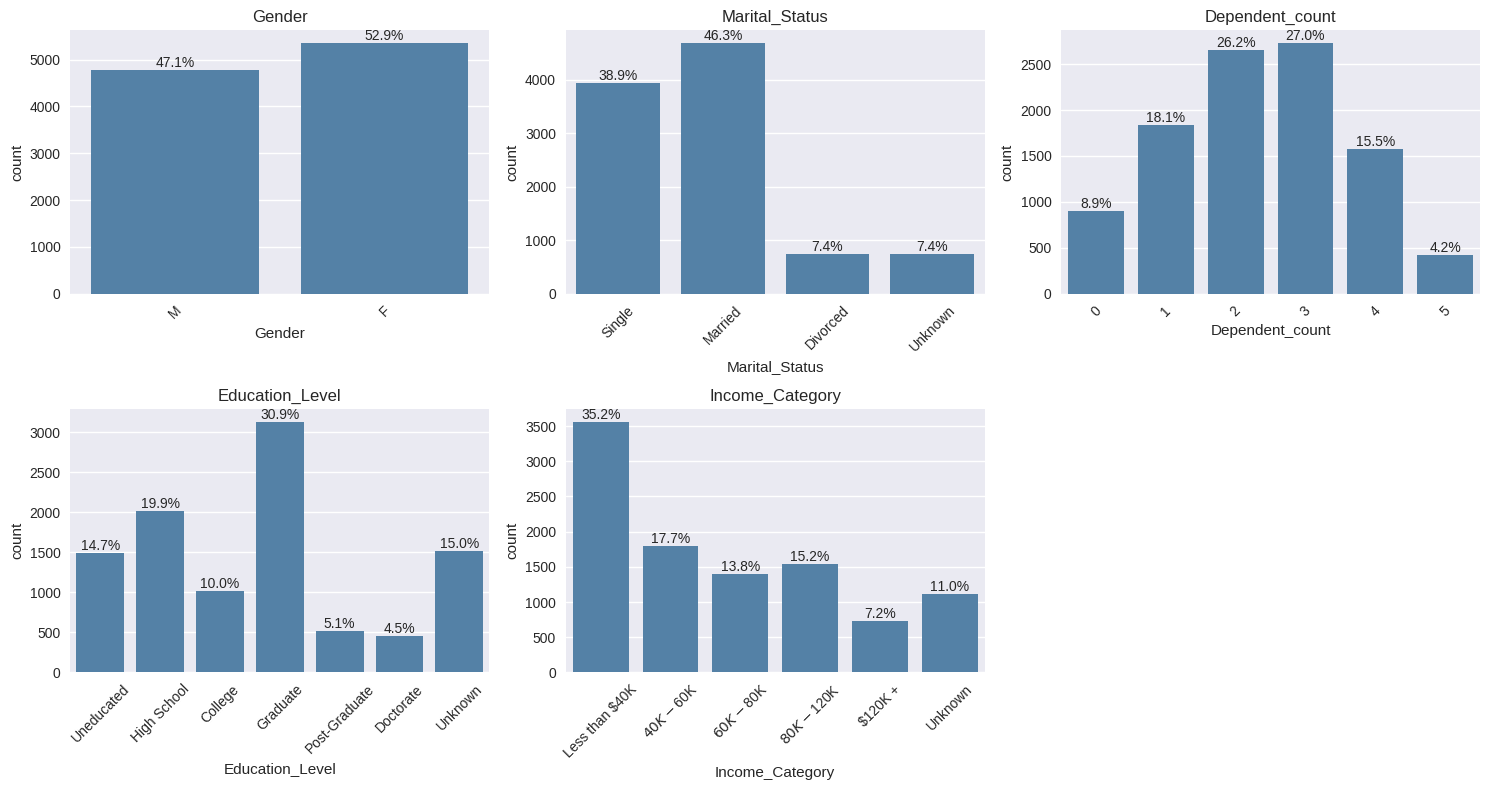

In [ ]:
# Customer demographic categorical fields
demographic_cols = ['Gender', 'Marital_Status', 'Dependent_count', 'Education_Level', 'Income_Category']

demographic_orders = {
  'Gender': ['M', 'F'],
  'Dependent_count': [0, 1, 2, 3, 4, 5],
  'Education_Level': ['Uneducated', 'High School', 'College', 'Graduate', 'Post-Graduate', 'Doctorate', 'Unknown'],
  'Income_Category': ['Less than $40K', '$40K - $60K', '$60K - $80K', '$80K - $120K', '$120K +', 'Unknown'],
  'Marital_Status': ['Single', 'Married', 'Divorced', 'Unknown']
}

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
axes = axes.flatten()

for i, col in enumerate(demographic_cols):
   sns.countplot(x=col, data=df, order=demographic_orders[col], ax=axes[i], color='steelblue')
   axes[i].set_title(col)
   axes[i].tick_params(axis='x', rotation=45)

   # Add percentage labels on bars
   total = len(df[col])
   for p in axes[i].patches:
       percentage = f'{100 * p.get_height() / total:.1f}%'
       axes[i].annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='bottom', fontsize=10)

axes[-1].set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
print("\n--- Churn Rate by Key Categorical Features ---")
for col in demographic_cols:
    churn_by_cat = df.groupby(col)['Churn'].mean().sort_values(ascending=False)
    print(f"\nChurn Rate by {col}:\n{churn_by_cat}")


--- Churn Rate by Key Categorical Features ---

Churn Rate by Gender:
Gender
F    0.173572
M    0.146152
Name: Churn, dtype: float64

Churn Rate by Marital_Status:
Marital_Status
Unknown     0.172230
Single      0.169414
Divorced    0.161765
Married     0.151269
Name: Churn, dtype: float64

Churn Rate by Dependent_count:
Dependent_count
3    0.176428
4    0.165184
2    0.157062
5    0.150943
0    0.149336
1    0.146355
Name: Churn, dtype: float64

Churn Rate by Education_Level:
Education_Level
Doctorate        0.210643
Post-Graduate    0.178295
Unknown          0.168532
Uneducated       0.159381
Graduate         0.155691
College          0.152024
High School      0.152012
Name: Churn, dtype: float64

Churn Rate by Income_Category:
Income_Category
$120K +           0.173315
Less than $40K    0.171862
Unknown           0.168165
$80K - $120K      0.157655
$40K - $60K       0.151397
$60K - $80K       0.134807
Name: Churn, dtype: float64


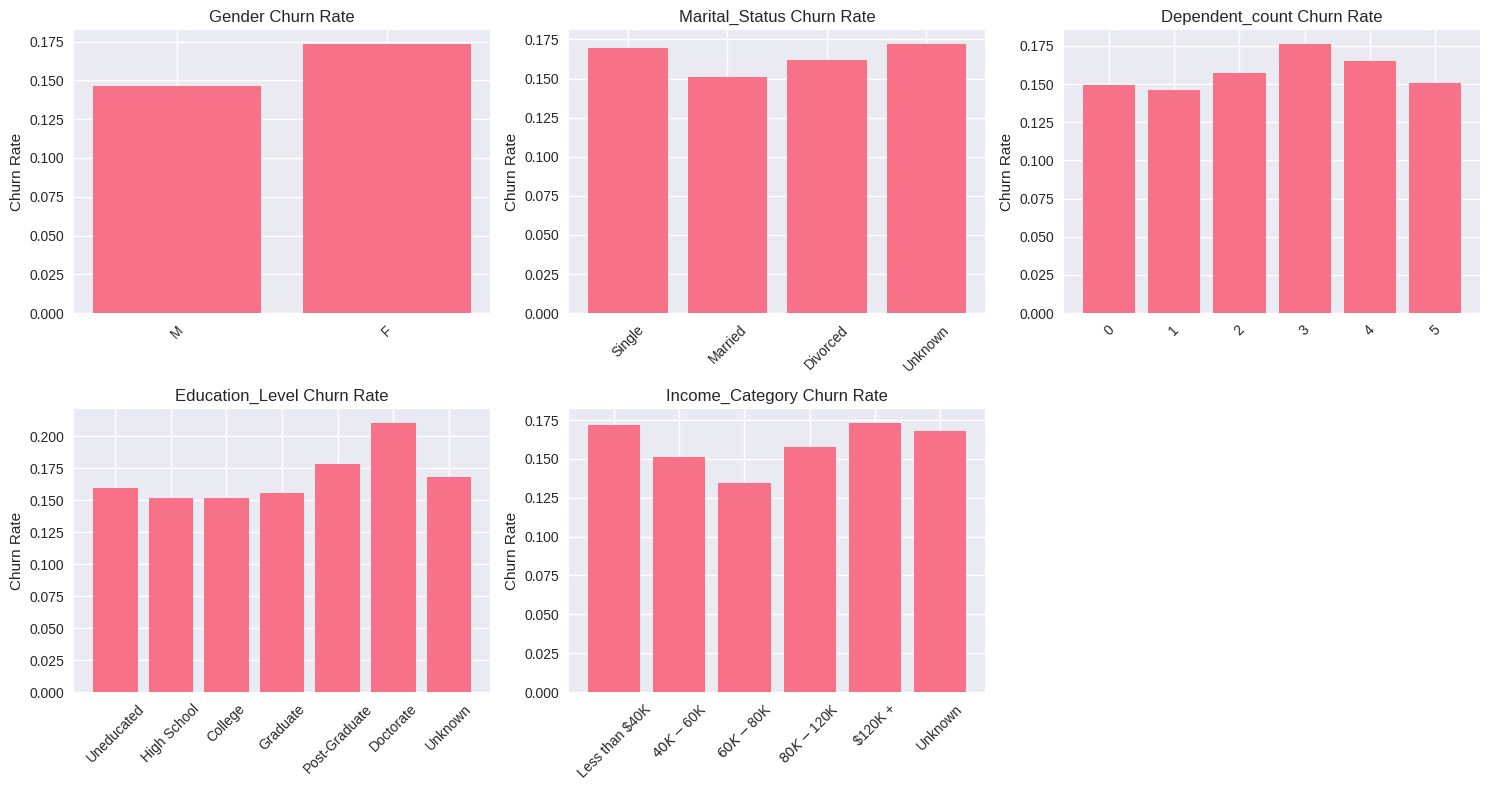

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
axes = axes.flatten()

for i, col in enumerate(demographic_cols):
    # Churn rate per category
    churn_rate = df.groupby(col)['Attrition_Flag'].apply(lambda x: (x=='Attrited Customer').mean())

    if demographic_orders[col]:
        churn_rate = churn_rate.reindex(demographic_orders[col])

    axes[i].bar(churn_rate.index.astype(str), churn_rate.values)
    axes[i].set_title(f'{col} Churn Rate')
    axes[i].set_ylabel('Churn Rate')
    axes[i].tick_params(axis='x', rotation=45)

axes[-1].set_visible(False)

plt.tight_layout()
plt.show()

### **---Bank Details**

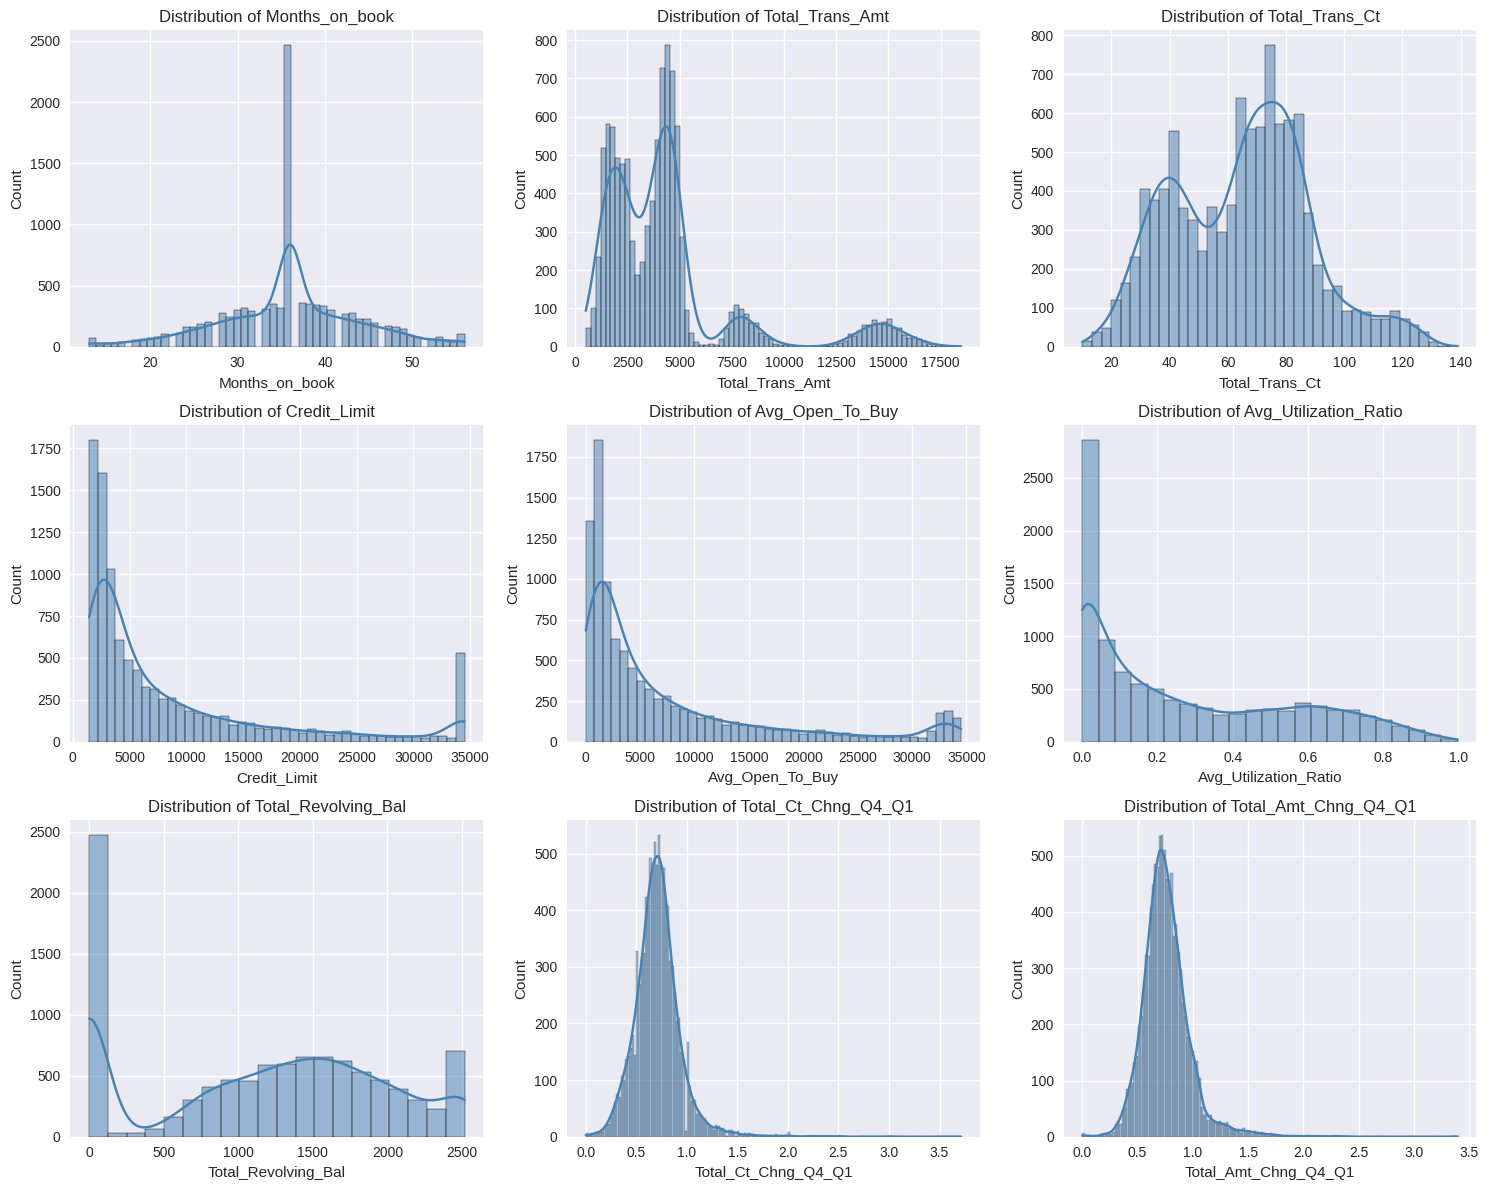

In [ ]:
# Bank numerical fields
bank_numerical_cols = [
   'Months_on_book', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Credit_Limit', 'Avg_Open_To_Buy', 'Avg_Utilization_Ratio','Total_Revolving_Bal', 'Total_Ct_Chng_Q4_Q1','Total_Amt_Chng_Q4_Q1',
]

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(bank_numerical_cols):
   sns.histplot(df[col], kde=True, ax=axes[i], color="steelblue")
   axes[i].set_title(f"Distribution of {col}")
   axes[i].set_xlabel(col)
   axes[i].set_ylabel("Count")

plt.tight_layout()
plt.show()

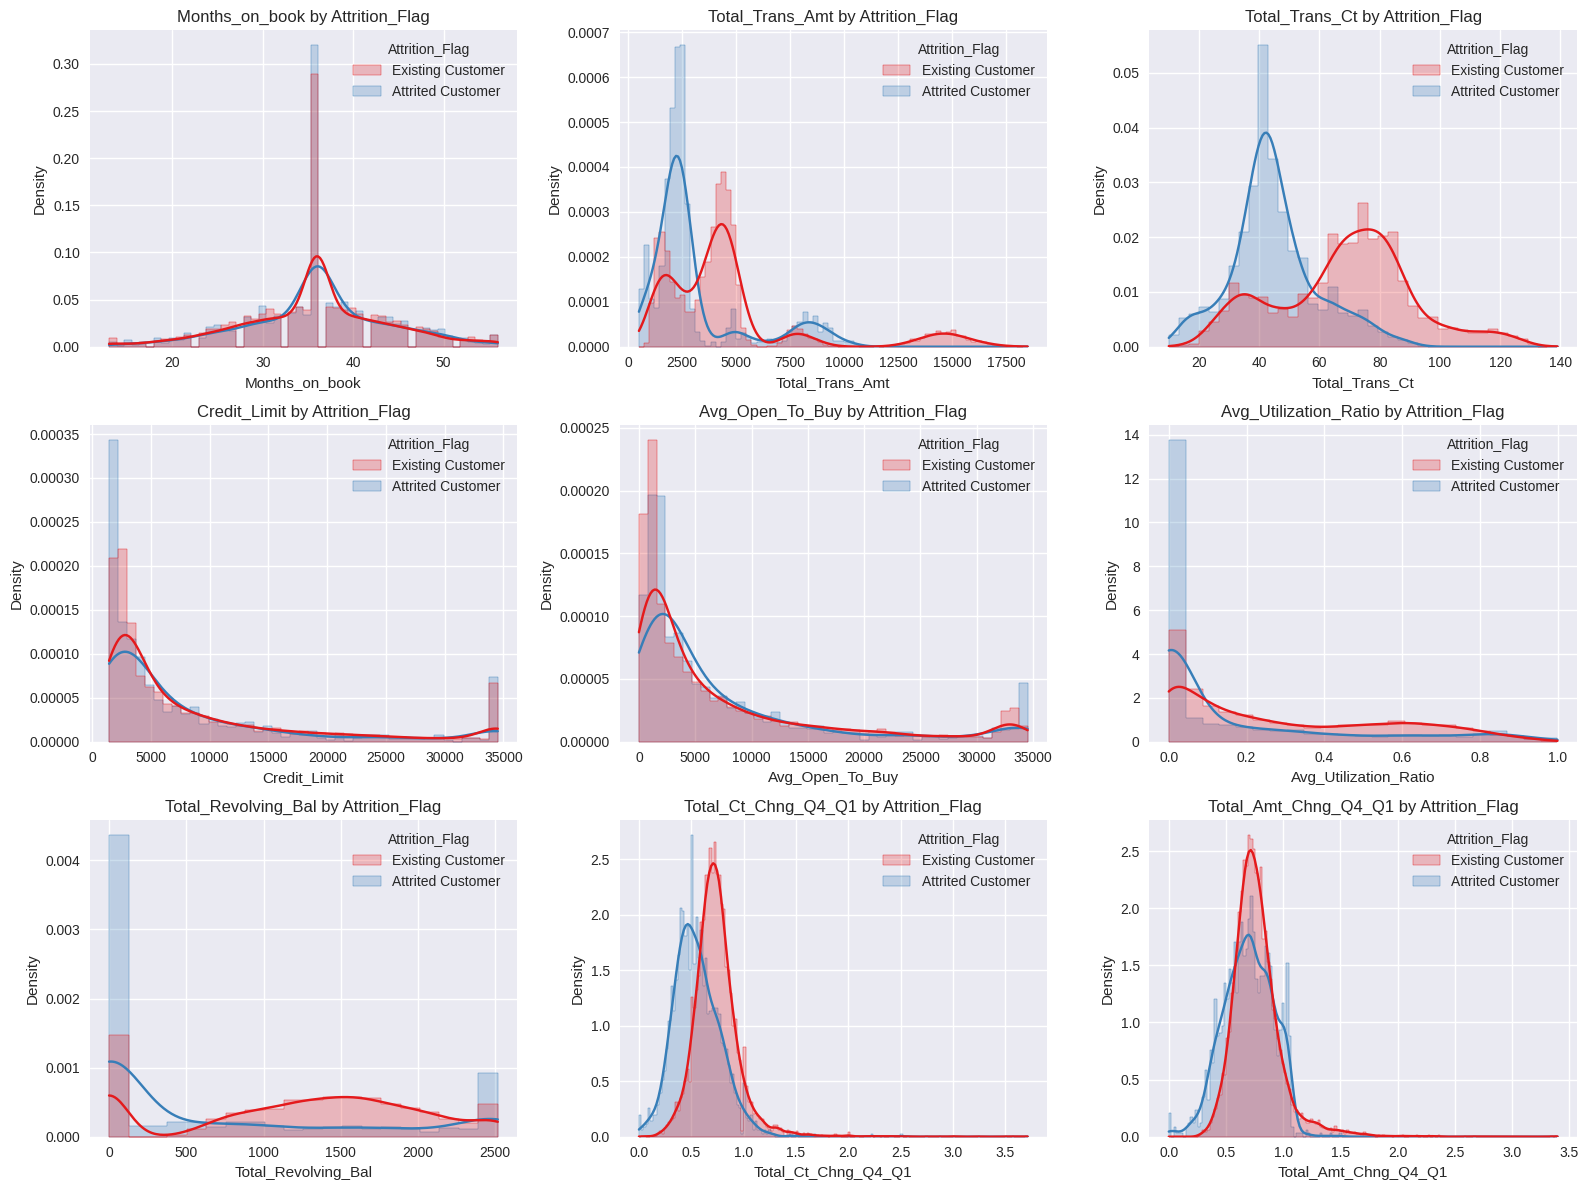

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(16, 12))
axes = axes.flatten()

for i, col in enumerate(bank_numerical_cols):
    sns.histplot(data=df, x=col, hue="Attrition_Flag", kde=True, ax=axes[i],
                 palette="Set1", element="step", stat="density", common_norm=False)
    axes[i].set_title(f"{col} by Attrition_Flag")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Density")

plt.tight_layout()
plt.show()

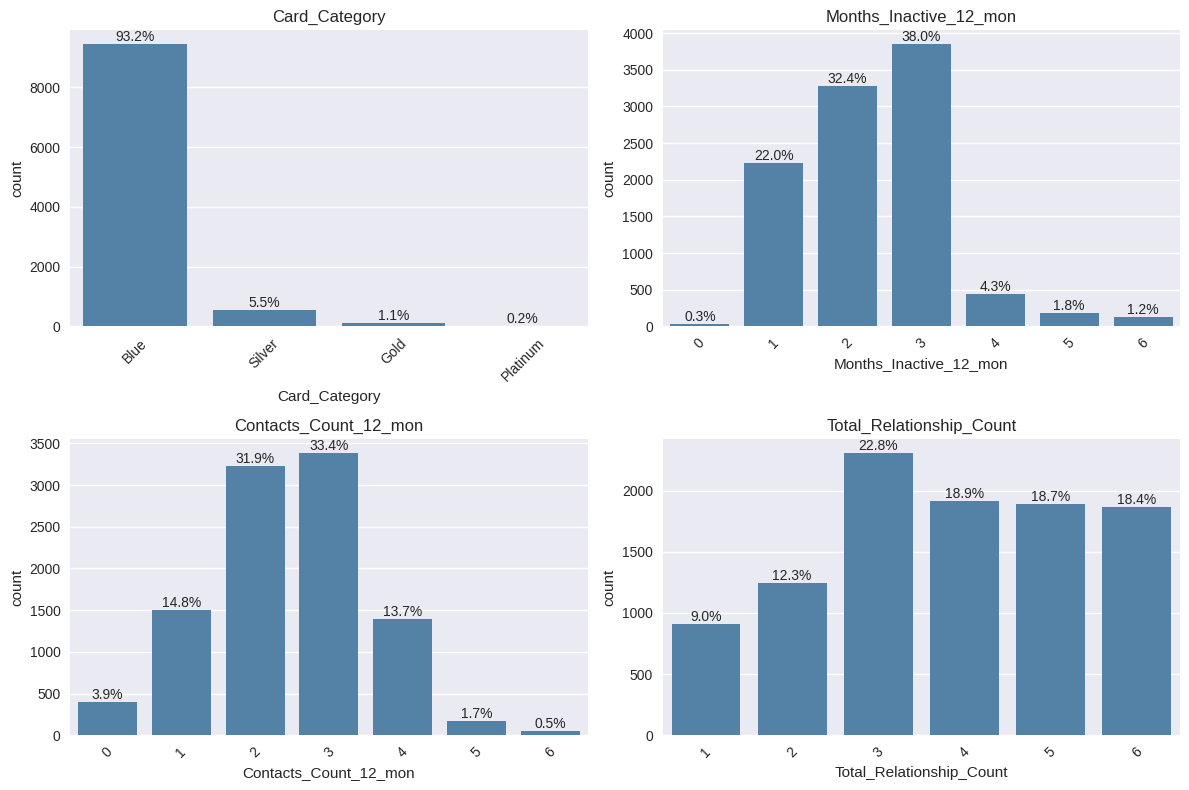

In [ ]:
# Bank account categorical/discrete fields
bank_categorical_cols = ['Card_Category', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Total_Relationship_Count']

bank_orders = {
 'Card_Category': ['Blue', 'Silver', 'Gold', 'Platinum'],
 'Months_Inactive_12_mon': None,
 'Contacts_Count_12_mon': None,
 'Total_Relationship_Count': None
}

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes = axes.flatten()

for i, col in enumerate(bank_categorical_cols):
   sns.countplot(x=col, data=df, order=bank_orders[col], ax=axes[i], color='steelblue')
   axes[i].set_title(col)
   axes[i].tick_params(axis='x', rotation=45)

   # Add percentage labels on bars
   total = len(df[col])
   for p in axes[i].patches:
       percentage = f'{100 * p.get_height() / total:.1f}%'
       axes[i].annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

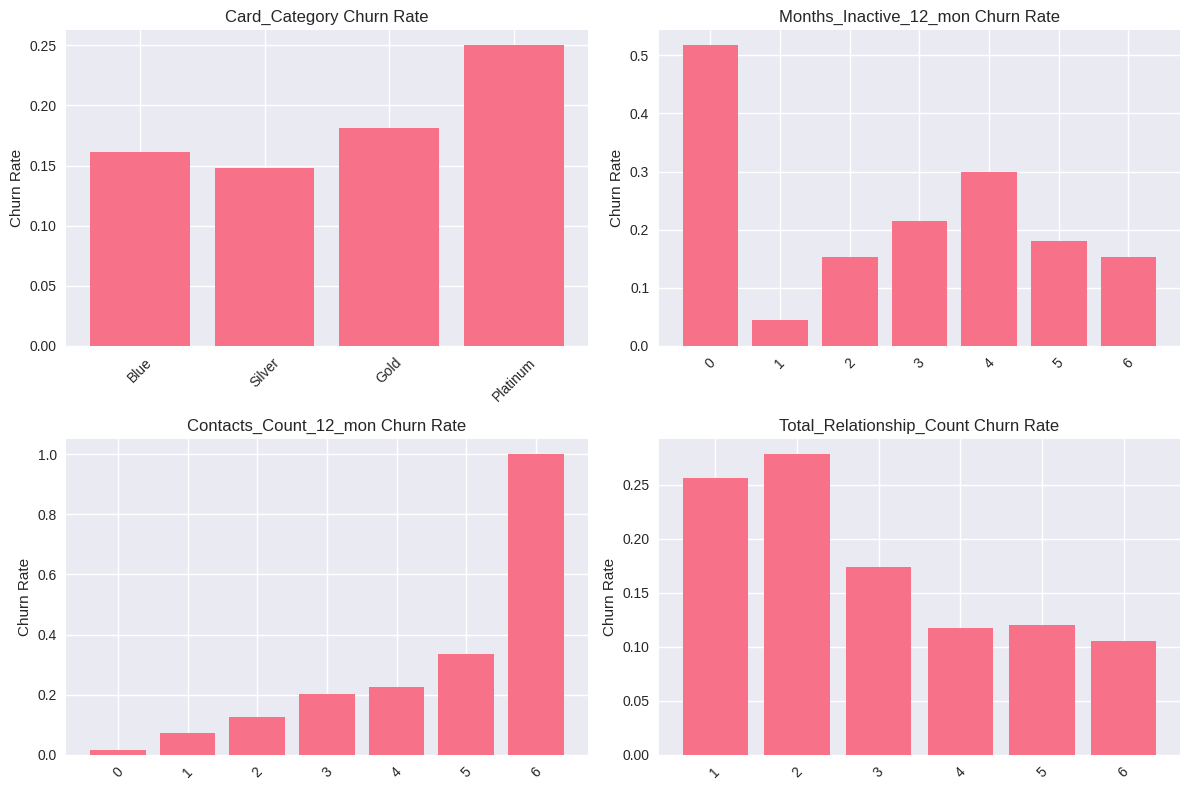

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes = axes.flatten()

for i, col in enumerate(bank_categorical_cols):
   # Compute churn rate per category
   churn_rate = df.groupby(col)['Attrition_Flag'].apply(lambda x: (x=='Attrited Customer').mean())

   if bank_orders[col]:
       churn_rate = churn_rate.reindex(bank_orders[col])

   # Plot on the corresponding axis
   axes[i].bar(churn_rate.index.astype(str), churn_rate.values)
   axes[i].set_title(f'{col} Churn Rate')
   axes[i].set_ylabel('Churn Rate')
   axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

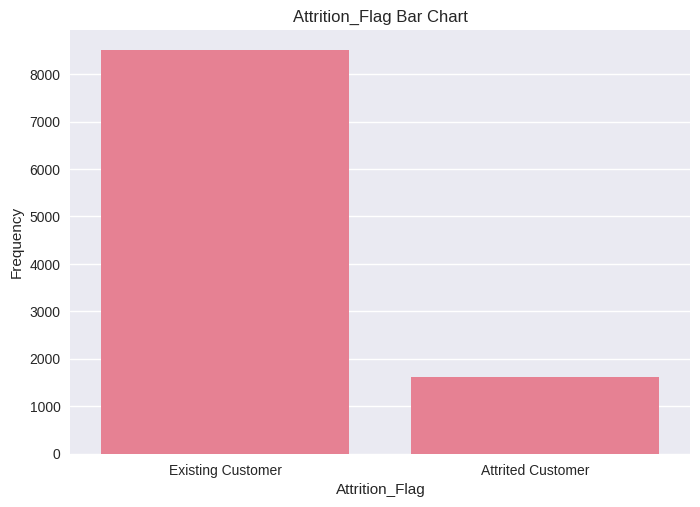

In [ ]:
# Bar chart for Attrition_Flag
sns.countplot(x='Attrition_Flag', data=df)
plt.title('Attrition_Flag Bar Chart')
plt.xlabel('Attrition_Flag')
plt.ylabel('Frequency')
plt.show()

### **---Correation Matrix Before Preprocessing**

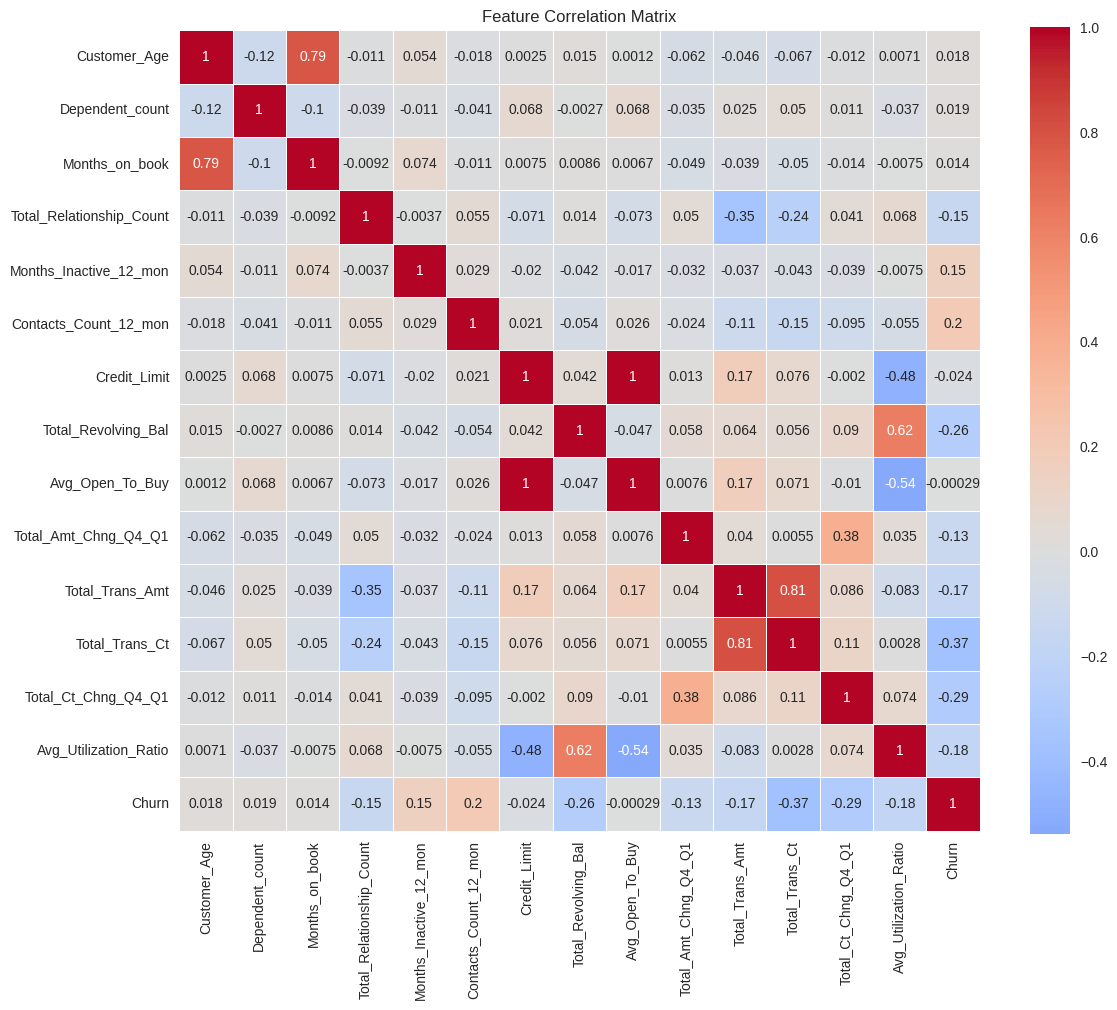

In [ ]:
# Correlation analysis for numerical features
numerical_features = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numerical_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

---
## **Data Preprocessing**

### **--- Preprocessing Pipeline Definition & Model Training and Evaluation**

In [19]:
# Create a copy for preprocessing
df_processed = df.copy()

In [20]:
# Fill missing values
for col in df_processed.columns:
    if df_processed[col].dtype == 'object':
        df_processed[col] = df_processed[col].fillna("Unknown")
    else:
        df_processed[col] = df_processed[col].fillna(df_processed[col].median())

In [ ]:
# # Advanced feature engineering
# print("🔧 Feature Engineering:")

# # 1. Engagement Score
# if all(col in df_processed.columns for col in ['Total_Trans_Ct', 'Months_on_book']):
#     df_processed['Monthly_Transaction_Rate'] = df_processed['Total_Trans_Ct'] / (df_processed['Months_on_book'] + 1)

# # 2. Credit Efficiency
# if all(col in df_processed.columns for col in ['Total_Trans_Amt', 'Credit_Limit']):
#     df_processed['Credit_Efficiency'] = df_processed['Total_Trans_Amt'] / (df_processed['Credit_Limit'] + 1)

# # 3. Relationship Intensity
# if all(col in df_processed.columns for col in ['Total_Relationship_Count', 'Months_on_book']):
#     df_processed['Relationship_Intensity'] = df_processed['Total_Relationship_Count'] / (df_processed['Months_on_book'] / 12 + 1)

# # 4. Activity Score
# if all(col in df_processed.columns for col in ['Months_Inactive_12_mon', 'Contacts_Count_12_mon']):
#     df_processed['Activity_Score'] = (12 - df_processed['Months_Inactive_12_mon']) + df_processed['Contacts_Count_12_mon']

# # 5. Financial Stability
# if all(col in df_processed.columns for col in ['Total_Revolving_Bal', 'Credit_Limit']):
#     df_processed['Financial_Stability'] = 1 - (df_processed['Total_Revolving_Bal'] / (df_processed['Credit_Limit'] + 1))

# print(f"Created {5} new engineered features")

In [21]:
y = df_processed['Churn']
X = df_processed.drop(columns=['Attrition_Flag', 'Churn'])

**Data Split and Feature Identification**

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [23]:
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

In [24]:
print(f"Numerical features: {numerical_features}")
print(f"Categorical features: {categorical_features}")
print("-----------------------------------------------")
print(f"Numerical: {len(numerical_features)} | Categorical: {len(categorical_features)}")
print("Train class balance:", Counter(y_train), "| Test:", Counter(y_test))

Numerical features: ['Customer_Age', 'Dependent_count', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio']
Categorical features: ['Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']
-----------------------------------------------
Numerical: 14 | Categorical: 5
Train class balance: Counter({0: 5949, 1: 1139}) | Test: Counter({0: 2551, 1: 488})


In [25]:
X_train.head()

,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
8948,44,F,3,Uneducated,Married,Less than $40K,Blue,36,2,3,3,6680.0,1839,4841.0,0.617,7632,95,0.532,0.275
6665,39,F,1,Graduate,Single,Unknown,Blue,34,3,1,1,2884.0,2517,367.0,0.693,4809,87,0.740,0.873
7119,52,M,1,Unknown,Married,$80K - $120K,Blue,36,4,2,2,14858.0,1594,13264.0,0.510,4286,72,0.636,0.107
2257,34,M,0,Graduate,Married,$40K - $60K,Blue,17,4,1,4,2638.0,2092,546.0,0.591,1868,43,0.344,0.793
3461,47,M,5,Doctorate,Single,Less than $40K,Blue,36,3,1,2,8896.0,1338,7558.0,0.741,4252,70,0.591,0.150


**Preprocessing Pipeline Definition**

In [28]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='passthrough'
)

In [29]:
# Apply the transformation to the training data
X_train_processed_array = preprocessor.fit_transform(X_train)

# Convert the resulting NumPy array back into a DataFrame for readability
feature_names = preprocessor.get_feature_names_out()
X_train_processed_df = pd.DataFrame(X_train_processed_array, columns=feature_names)

print("--- Data After Preprocessing ---")
print(X_train_processed_df.head())
print(f"\nShape of the Transformed Data: {X_train_processed_df.shape}")

--- Data After Preprocessing ---
   num__Customer_Age  num__Dependent_count  num__Months_on_book  \
0          -0.296582              0.507138             0.000336   
1          -0.920631             -1.035607            -0.250447   
2           0.701897             -1.035607             0.000336   
3          -1.544680             -1.806980            -2.382104   
4           0.077848              2.049884             0.000336   

   num__Total_Relationship_Count  num__Months_Inactive_12_mon  \
0                      -1.157385                     0.654904   
1                      -0.516132                    -1.333938   
2                       0.125120                    -0.339517   
3                       0.125120                    -1.333938   
4                      -0.516132                    -1.333938   

   num__Contacts_Count_12_mon  num__Credit_Limit  num__Total_Revolving_Bal  \
0                    0.491960          -0.214374                  0.829707   
1                


**Model Training and Evaluation**

In [30]:
models_baseline = {
    'Logistic Regression (Balanced)': LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced'),
    'Random Forest (Balanced)': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    'Gradient Boosting Classifier': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'AdaBoost Classifier': AdaBoostClassifier(n_estimators=100, random_state=42),
    'XGBoost Classifier': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', scale_pos_weight=y_train.value_counts()[0]/y_train.value_counts()[1]), # XGBoost uses scale_pos_weight
    'Linear SVC (Balanced)': LinearSVC(random_state=42, class_weight='balanced', max_iter=2000),
    'LightGBM Classifier': LGBMClassifier(random_state=42, is_unbalance=True) # LightGBM imbalance setting
}

In [31]:
results_baseline = {}
fprs_baseline = {}
tprs_baseline = {}

for name, model in models_baseline.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    report = classification_report(y_test, y_pred, target_names=['Existing (0)', 'Attrited (1)'], output_dict=True)

    # Handling AUC for models that don't output probability (like LinearSVC)
    try:
        y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
        auc_score = roc_auc_score(y_test, y_pred_proba)
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        fprs_baseline[name] = fpr
        tprs_baseline[name] = tpr
    except AttributeError:
        auc_score = 'N/A'

    results_baseline[name] = {
        'Precision (Churn)': report['Attrited (1)']['precision'],
        'Recall (Churn)': report['Attrited (1)']['recall'],
        'F1-Score (Churn)': report['Attrited (1)']['f1-score'],
        'AUC': auc_score
    }

[LightGBM] [Info] Number of positive: 1139, number of negative: 5949
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000989 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2070
[LightGBM] [Info] Number of data points in the train set: 7088, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.160694 -> initscore=-1.653072
[LightGBM] [Info] Start training from score -1.653072


In [32]:
print("\n--- Model Comparison Results (Class Weight/Loss) ---")
results_df_baseline = pd.DataFrame.from_dict(results_baseline, orient='index')
print(results_df_baseline)


--- Model Comparison Results (Class Weight/Loss) ---
                                Precision (Churn)  Recall (Churn)  \
Logistic Regression (Balanced)           0.521181        0.831967   
Random Forest (Balanced)                 0.916883        0.723361   
Gradient Boosting Classifier             0.931604        0.809426   
AdaBoost Classifier                      0.892449        0.799180   
XGBoost Classifier                       0.905544        0.903689   
Linear SVC (Balanced)                    0.518614        0.827869   
LightGBM Classifier                      0.877470        0.909836   

                                F1-Score (Churn)       AUC  
Logistic Regression (Balanced)          0.640884  0.917348  
Random Forest (Balanced)                0.808706  0.984568  
Gradient Boosting Classifier            0.866228   0.98751  
AdaBoost Classifier                     0.843243  0.980832  
XGBoost Classifier                      0.904615  0.992149  
Linear SVC (Balanced)      

In [41]:
smote_models = {
    'Random Forest (SMOTE)': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost (SMOTE)': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    'LightGBM (SMOTE)': LGBMClassifier(random_state=42) # Added LightGBM
}

In [42]:
results_smote = {}
fprs_smote = {}
tprs_smote = {}

smote = SMOTE(random_state=42)

for name, model in smote_models.items():
    # Use ImbPipeline to ensure SMOTE is only applied to training fold during CV/training
    pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', smote),
        ('classifier', model)
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

    report = classification_report(y_test, y_pred, target_names=['Existing (0)', 'Attrited (1)'], output_dict=True)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

    fprs_smote[name] = fpr
    tprs_smote[name] = tpr
    results_smote[name] = {
        'Precision (Churn)': report['Attrited (1)']['precision'],
        'Recall (Churn)': report['Attrited (1)']['recall'],
        'F1-Score (Churn)': report['Attrited (1)']['f1-score'],
        'AUC': auc_score
    }


[LightGBM] [Info] Number of positive: 5949, number of negative: 5949
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003983 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8605
[LightGBM] [Info] Number of data points in the train set: 11898, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


In [43]:
print("\n--- Model Comparison Results (SMOTE) ---")
results_df_smote = pd.DataFrame.from_dict(results_smote, orient='index')
print(results_df_smote)


--- Model Comparison Results (SMOTE) ---
                       Precision (Churn)  Recall (Churn)  F1-Score (Churn)  \
Random Forest (SMOTE)           0.863539        0.829918          0.846395   
XGBoost (SMOTE)                 0.915074        0.883197          0.898853   
LightGBM (SMOTE)                0.903564        0.883197          0.893264   

                            AUC  
Random Forest (SMOTE)  0.983004  
XGBoost (SMOTE)        0.990843  
LightGBM (SMOTE)       0.991210  


### **--- Hyperparameter Tuning (Grid Search on Model: GBC)**

In [ ]:
# # Create a pipeline with the GBC classifier
# gbc_pipe = Pipeline(steps=[('preprocessor', preprocessor),
#                            ('classifier', GradientBoostingClassifier(random_state=42))])

In [ ]:
# # Define the parameter grid to search
# param_grid = {
#     'classifier__n_estimators': [100, 200],
#     'classifier__learning_rate': [0.1, 0.2],
#     'classifier__max_depth': [3, 4]
# }

In [ ]:
# # Optimize for F1-score due to imbalance
# grid_search = GridSearchCV(gbc_pipe, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1)
# grid_search.fit(X_train, y_train)

In [ ]:
# # Evaluate the best model
# best_gbc = grid_search.best_estimator_
# y_pred_proba_tuned = best_gbc.predict_proba(X_test)[:, 1]
# tuned_auc = roc_auc_score(y_test, y_pred_proba_tuned)
# y_pred_tuned = best_gbc.predict(X_test)
# tuned_report = classification_report(y_test, y_pred_tuned, target_names=['Existing (0)', 'Attrited (1)'], output_dict=True)

In [ ]:
# print(f"\nBest GBC Parameters: {grid_search.best_params_}")
# print(f"Tuned GBC F1-Score (Churn): {tuned_report['Attrited (1)']['f1-score']:.4f}")
# print(f"Tuned GBC AUC: {tuned_auc:.4f}")

### **--- Hyperparameter Tuning (Grid Search on Model: XGBoost)**

In [44]:
pos_weight = (y_train.value_counts()[0] / y_train.value_counts()[1])  # #neg / #pos

In [45]:
xgb_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',     # model metric; sklearn scoring handles selection
        tree_method='hist',        # fast + accurate on tabular
        random_state=42,
        use_label_encoder=False
    ))
])

In [46]:
xgb_param_grid = {
    'classifier__n_estimators':      [300, 600],      #  [300, 500, 800]
    'classifier__learning_rate':     [0.05, 0.10],    #  [0.03, 0.05, 0.1]
    'classifier__max_depth':         [3, 4],          #  [3, 4, 5]
    'classifier__min_child_weight':  [1, 3],          #  [1, 3, 5]
    'classifier__subsample':         [0.8],
    'classifier__colsample_bytree':  [0.8],
    'classifier__reg_lambda':        [1.0, 5.0],
    'classifier__gamma':             [0],
    'classifier__scale_pos_weight':  [pos_weight],    # fixed from imbalance
}

In [60]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# If F1 on churn is the KPI, use scoring='f1'
xgb_search = GridSearchCV(
    estimator=xgb_pipe,
    param_grid=xgb_param_grid,
    scoring='f1',
    cv=cv,
    n_jobs=-1,
    verbose=3
)
xgb_search.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['Customer_Age',
                                                                          'Dependent_count',
                                                                          'Months_on_book',
                                                                          'Total_Relationship_Count',
                                                                          'Months_Inactive_12_mon',
                                                                          'Contacts_Count_12_mon',
                                                                          'Credit_Limit',
                                                                          'Total_Revolv...
             param_grid={'classifier__colsample_bytree': [0.8],
                         'classifier__gamma': [0],
                         'classifier__learning_rate': [0.05, 0.1],
                         'classifier__max_depth': [3, 4],
                         'classifier__min_child_weight': [1, 3],
                         'classifier__n_estimators': [300, 600],
                         'classifier__reg_lambda': [1.0, 5.0],
                         'classifier__scale_pos_weight': [np.float64(5.223002633889377)],
                         'classifier__subsample': [0.8]},
             scoring='f1', verbose=3)

In [48]:
# Evaluate the best model
best_xgb = xgb_search.best_estimator_
y_pred_proba_tuned = best_xgb.predict_proba(X_test)[:, 1]
tuned_auc = roc_auc_score(y_test, y_pred_proba_tuned)

y_pred_tuned = best_xgb.predict(X_test)
tuned_report = classification_report(y_test, y_pred_tuned, target_names=['Existing (0)', 'Attrited (1)'], output_dict=True)

In [49]:
print(f"\nBest XGB Parameters: {xgb_search.best_params_}")
print(f"Tuned XGB F1-Score (Churn): {tuned_report['Attrited (1)']['f1-score']:.4f}")
print(f"Tuned XGB AUC: {tuned_auc:.4f}")


Best XGB Parameters: {'classifier__colsample_bytree': 0.8, 'classifier__gamma': 0, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 4, 'classifier__min_child_weight': 1, 'classifier__n_estimators': 600, 'classifier__reg_lambda': 1.0, 'classifier__scale_pos_weight': np.float64(5.223002633889377), 'classifier__subsample': 0.8}
Tuned XGB F1-Score (Churn): 0.9018
Tuned XGB AUC: 0.9934


In [50]:
# Add tuned XGB to ROC data for visualization
fpr_tuned, tpr_tuned, _ = roc_curve(y_test, y_pred_proba_tuned)
fprs_baseline['XGB (Tuned)'] = fpr_tuned
tprs_baseline['XGB (Tuned)'] = tpr_tuned

### **--- Visualization: ROC Curve Plotting**

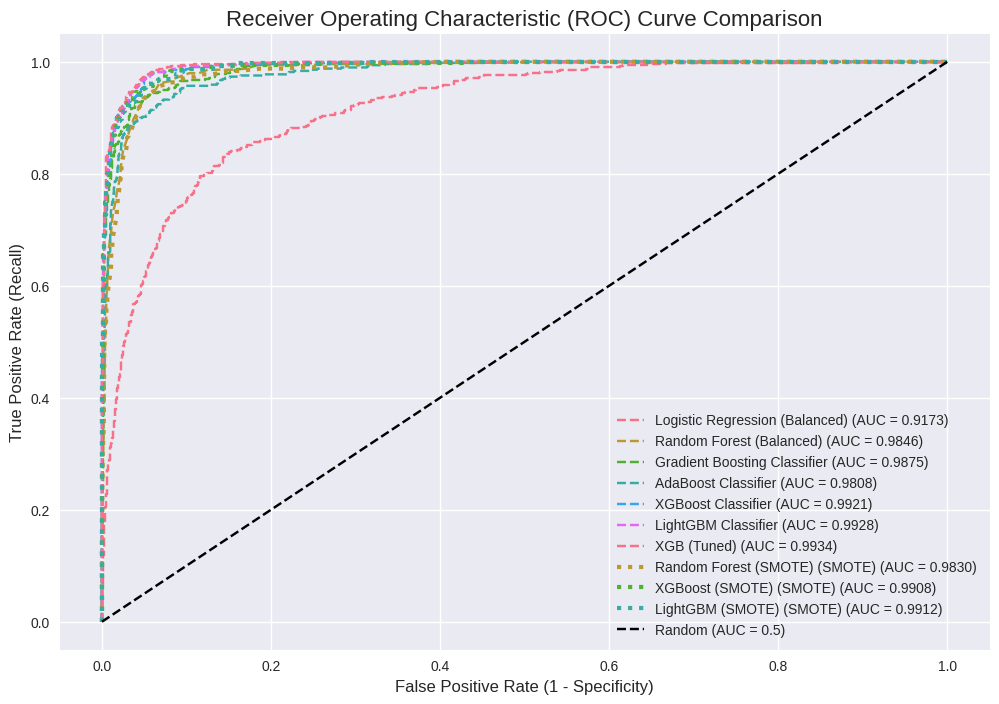

In [53]:
# Plotting the ROC curves for BASELINE models and TUNED XGB
plt.figure(figsize=(12, 8))
plt.title('Receiver Operating Characteristic (ROC) Curve Comparison', fontsize=16)

# Plot Baseline/Tuned Models
for name in fprs_baseline:
    if name not in ['Linear SVC (Balanced)']: # Exclude non-probabilistic models
        # Use AUC from the results_baseline, or tuned_auc for the tuned model
        auc_val = results_baseline.get(name, {}).get("AUC", tuned_auc)
        plt.plot(fprs_baseline[name], tprs_baseline[name],
                 label=f'{name} (AUC = {auc_val:.4f})',
                 linestyle='-' if 'GBC' in name else '--')

# Plot SMOTE Models (Use a distinct style)
for name in fprs_smote:
    auc_val = results_smote.get(name, {}).get("AUC")
    plt.plot(fprs_smote[name], tprs_smote[name],
             label=f'{name} (SMOTE) (AUC = {auc_val:.4f})',
             linestyle=':', linewidth=3)


plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5)')
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
plt.ylabel('True Positive Rate (Recall)', fontsize=12)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True)
plt.show()

---
## **Feature Importance Analysis (for business interpretation)**

In [54]:
# Extract importances from the best model (Tuned GBC)
feature_names = preprocessor.get_feature_names_out()
importances = best_xgb['classifier'].feature_importances_
sorted_indices = np.argsort(importances)[::-1]
top_15_features = [(feature_names[i], importances[i]) for i in sorted_indices[:15]]

In [55]:
print("\n--- Top 15 Feature Importances (from Tuned GBC) ---")
for feature, importance in top_15_features:
    # Clean up feature names for display
    clean_feature = feature.split('__')[-1].replace('cat__', '')
    print(f"{clean_feature:<30}: {importance:.4f}")

# Visualize Top 15 Feature Importances
features, importances_values = zip(*top_15_features)
features = [f.split('__')[-1].replace('cat__', '') for f in features] # Clean names for plot


--- Top 15 Feature Importances (from Tuned GBC) ---
Total_Trans_Ct                : 0.1790
Total_Revolving_Bal           : 0.1096
Total_Trans_Amt               : 0.1004
Total_Relationship_Count      : 0.0790
Card_Category_Platinum        : 0.0709
Total_Ct_Chng_Q4_Q1           : 0.0494
Months_Inactive_12_mon        : 0.0437
Total_Amt_Chng_Q4_Q1          : 0.0325
Contacts_Count_12_mon         : 0.0283
Gender_F                      : 0.0271
Customer_Age                  : 0.0218
Avg_Utilization_Ratio         : 0.0204
Income_Category_$120K +       : 0.0162
Avg_Open_To_Buy               : 0.0160
Credit_Limit                  : 0.0157


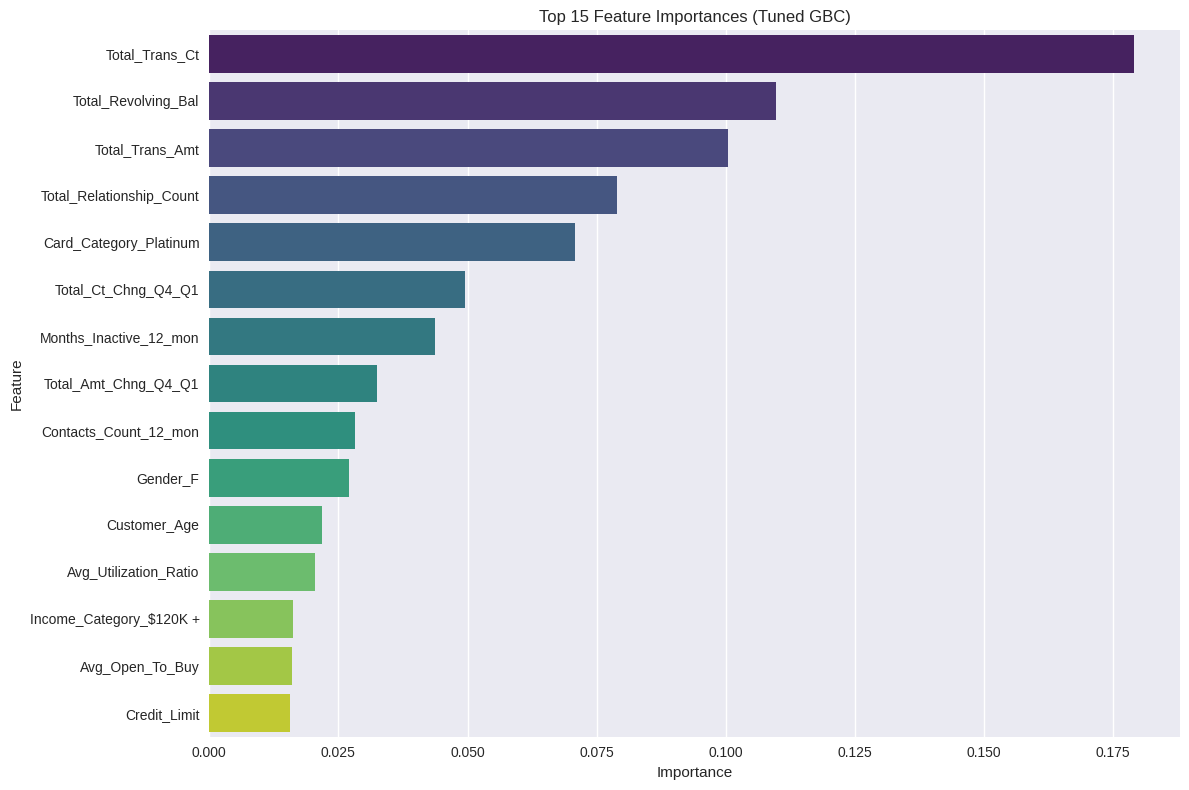

In [56]:
plt.figure(figsize=(12, 8))
sns.barplot(x=list(importances_values), y=list(features), palette='viridis')
plt.title('Top 15 Feature Importances (Tuned GBC)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

---
## **Predicting on New Data**

In [57]:
import pandas as pd
import numpy as np

# 0. Choose a decision threshold for churn (1). Keep 0.50 unless you tuned a better one.
THRESHOLD = 0.50

# 1. EXACT raw feature names expected (all features you trained on, EXCEPT 'CLIENTNUM', 'Attrition_Flag',
#     'Churn', and the two Naive_Bayes columns which you dropped before training).
EXPECTED_COLS = [
    'Customer_Age','Gender','Dependent_count','Education_Level','Marital_Status','Income_Category',
    'Card_Category','Months_on_book','Total_Relationship_Count','Months_Inactive_12_mon',
    'Contacts_Count_12_mon','Credit_Limit','Total_Revolving_Bal','Avg_Open_To_Buy',
    'Total_Amt_Chng_Q4_Q1','Total_Trans_Amt','Total_Trans_Ct','Total_Ct_Chng_Q4_Q1','Avg_Utilization_Ratio'
]

def predict_churn_for_one(sample_dict, fitted_pipeline, threshold=THRESHOLD):
    """
    sample_dict: raw customer features in original column names (strings for categoricals)
    fitted_pipeline: your trained Pipeline(preprocessor -> XGBClassifier)
    """
    # Create single-row DataFrame
    df_new = pd.DataFrame([sample_dict])

    # Sanity: ensure all expected columns exist; add any missing with NaN
    for c in EXPECTED_COLS:
        if c not in df_new.columns:
            df_new[c] = np.nan
    # Only keep expected columns (ignore accidental extras)
    df_new = df_new[EXPECTED_COLS]

    # (Optional) Light missing handling matching your training step:
    #   - categoricals -> 'Unknown'
    #   - numerics -> leave as-is (the safest is to add SimpleImputer in your preprocessor,
    #     but if you filled NAs before training and your inputs are complete, you can skip this)
    cat_cols = df_new.select_dtypes(include='object').columns
    df_new[cat_cols] = df_new[cat_cols].fillna('Unknown')

    # 2. Predict probability for the positive class (churn = 1)
    proba = fitted_pipeline.predict_proba(df_new)[:, 1][0]
    label = int(proba >= threshold)

    return {
        "churn_probability": round(float(proba), 5), # Format to 4 decimal places
        "predicted_label": label,  # 1 = churner, 0 = non-churner
        "threshold_used": float(threshold)
    }

# ---- Example usage ----

example_customer = {
    "Customer_Age": 45,
    "Gender": "F",
    "Dependent_count": 2,
    "Education_Level": "Graduate",
    "Marital_Status": "Married",
    "Income_Category": "$60K - $80K",
    "Card_Category": "Blue",
    "Months_on_book": 39,
    "Total_Relationship_Count": 3,
    "Months_Inactive_12_mon": 1,
    "Contacts_Count_12_mon": 2,
    "Credit_Limit": 12691.0,
    "Total_Revolving_Bal": 777,
    "Avg_Open_To_Buy": 11914.0,
    "Total_Amt_Chng_Q4_Q1": 1.335,
    "Total_Trans_Amt": 1144,
    "Total_Trans_Ct": 42,
    "Total_Ct_Chng_Q4_Q1": 0.625,
    "Avg_Utilization_Ratio": 0.06
}

example_customer2 = {
    "Customer_Age": 45,
    "Gender": "F",
    "Dependent_count": 2,
    "Education_Level": "Graduate",
    "Marital_Status": "Married",
    "Income_Category": "$60K - $80K",
    "Card_Category": "Blue",
    "Months_on_book": 39,               # ~3 years on book
    "Total_Relationship_Count": 1,      # very few products/relations
    "Months_Inactive_12_mon": 6,        # high inactivity
    "Contacts_Count_12_mon": 6,         # many contacts (complaints/reminders)
    "Credit_Limit": 2000.0,             # low limit
    "Total_Revolving_Bal": 1500.0,
    "Avg_Open_To_Buy": 1500.0,          # must equal Credit_Limit - Total_Revolving_Bal
    "Total_Amt_Chng_Q4_Q1": 0.35,       # big drop in spend (<< 1.0)
    "Total_Trans_Amt": 400,             # very low yearly amount
    "Total_Trans_Ct": 8,                # very few transactions
    "Total_Ct_Chng_Q4_Q1": 0.30,        # big drop in transaction count
    "Avg_Utilization_Ratio": 0.25       # = Total_Revolving_Bal / Credit_Limit
}

result = predict_churn_for_one(example_customer2, best_xgb, threshold=0.50)
print(result)
# -> {'churn_probability': 0.xx, 'predicted_label': 0/1, 'threshold_used': 0.5}

{'churn_probability': 0.99998, 'predicted_label': 1, 'threshold_used': 0.5}


### **Export the Tuned model and check it**

In [58]:
import joblib

# Export the tuned XGBoost model
joblib.dump(best_xgb, 'tuned_xgboost_churn_model.joblib')

print("Tuned XGBoost model exported successfully as 'tuned_xgboost_churn_model.joblib'")

Tuned XGBoost model exported successfully as 'tuned_xgboost_churn_model.joblib'


In [59]:
# Load the saved model
try:
    loaded_model = joblib.load('tuned_xgboost_churn_model.joblib')
    print("Model loaded successfully.")

    # 0. Choose a decision threshold for churn (1). Keep 0.50 unless you tuned a better one.
    THRESHOLD = 0.50

    # 1. EXACT raw feature names expected (all features you trained on, EXCEPT 'CLIENTNUM', 'Attrition_Flag',
    #     'Churn', and the two Naive_Bayes columns which you dropped before training).
    EXPECTED_COLS = [
        'Customer_Age','Gender','Dependent_count','Education_Level','Marital_Status','Income_Category',
        'Card_Category','Months_on_book','Total_Relationship_Count','Months_Inactive_12_mon',
        'Contacts_Count_12_mon','Credit_Limit','Total_Revolving_Bal','Avg_Open_To_Buy',
        'Total_Amt_Chng_Q4_Q1','Total_Trans_Amt','Total_Trans_Ct','Total_Ct_Chng_Q4_Q1','Avg_Utilization_Ratio'
    ]

    def predict_churn_for_one(sample_dict, fitted_pipeline, threshold=THRESHOLD):
        """
        sample_dict: raw customer features in original column names (strings for categoricals)
        fitted_pipeline: your trained Pipeline(preprocessor -> XGBClassifier)
        """
        # Create single-row DataFrame
        df_new = pd.DataFrame([sample_dict])

        # Sanity: ensure all expected columns exist; add any missing with NaN
        for c in EXPECTED_COLS:
            if c not in df_new.columns:
                df_new[c] = np.nan
        # Only keep expected columns (ignore accidental extras)
        df_new = df_new[EXPECTED_COLS]

        # (Optional) Light missing handling matching your training step:
        #   - categoricals -> 'Unknown'
        #   - numerics -> leave as-is (the safest is to add SimpleImputer in your preprocessor,
        #     but if you filled NAs before training and your inputs are complete, you can skip this)
        cat_cols = df_new.select_dtypes(include='object').columns
        df_new[cat_cols] = df_new[cat_cols].fillna('Unknown')

        # 2. Predict probability for the positive class (churn = 1)
        proba = fitted_pipeline.predict_proba(df_new)[:, 1][0]
        label = int(proba >= threshold)

        return {
            "churn_probability": round(float(proba), 5), # Format to 4 decimal places
            "predicted_label": label,  # 1 = churner, 0 = non-churner
            "threshold_used": float(threshold)
        }

    # ---- Example usage ----

    example_customer = {
        "Customer_Age": 45,
        "Gender": "F",
        "Dependent_count": 2,
        "Education_Level": "Graduate",
        "Marital_Status": "Married",
        "Income_Category": "$60K - $80K",
        "Card_Category": "Blue",
        "Months_on_book": 39,
        "Total_Relationship_Count": 3,
        "Months_Inactive_12_mon": 1,
        "Contacts_Count_12_mon": 2,
        "Credit_Limit": 12691.0,
        "Total_Revolving_Bal": 777,
        "Avg_Open_To_Buy": 11914.0,
        "Total_Amt_Chng_Q4_Q1": 1.335,
        "Total_Trans_Amt": 1144,
        "Total_Trans_Ct": 42,
        "Total_Ct_Chng_Q4_Q1": 0.625,
        "Avg_Utilization_Ratio": 0.06
    }

    result = predict_churn_for_one(example_customer2, loaded_model, threshold=0.50)
    print(result)

except FileNotFoundError:
    print("Error: 'tuned_xgboost_churn_model.joblib' not found. Please ensure the model is trained and exported.")
except Exception as e:
    print(f"An error occurred: {e}")

Model loaded successfully.
{'churn_probability': 0.99998, 'predicted_label': 1, 'threshold_used': 0.5}


## **Download the EDA diagrams**


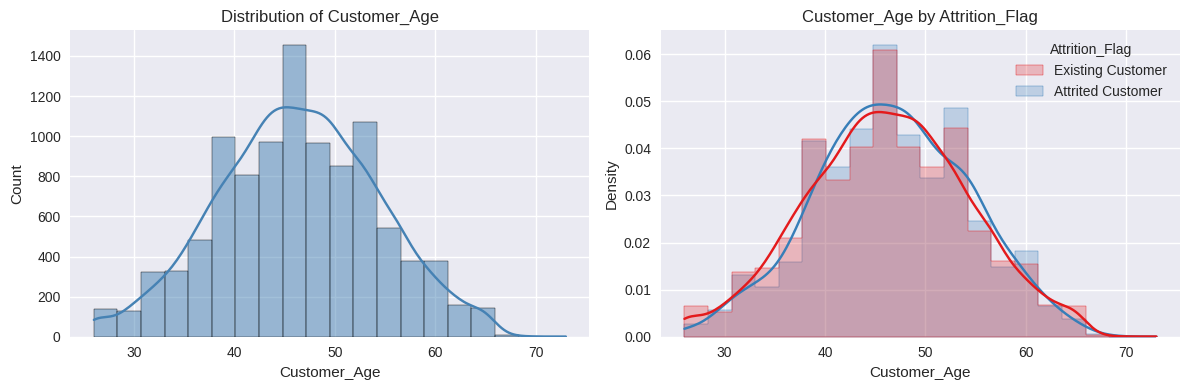

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Histogram
sns.histplot(df['Customer_Age'], kde=True, bins=20, ax=axes[0], color="steelblue")
axes[0].set_title("Distribution of Customer_Age")
axes[0].set_xlabel('Customer_Age')
axes[0].set_ylabel("Count")

# Distribution by Attrition
sns.histplot(data=df, x='Customer_Age', hue="Attrition_Flag", kde=True, bins=20, ax=axes[1],
            palette="Set1", element="step", stat="density", common_norm=False)
axes[1].set_title("Customer_Age by Attrition_Flag")
axes[1].set_xlabel('Customer_Age')
axes[1].set_ylabel("Density")

plt.tight_layout()
plt.savefig('customer_age_distribution.png', dpi=600, bbox_inches='tight')
plt.show()

**Reasoning**:
Add code to save the countplot figure for customer demographic features after displaying the plot.



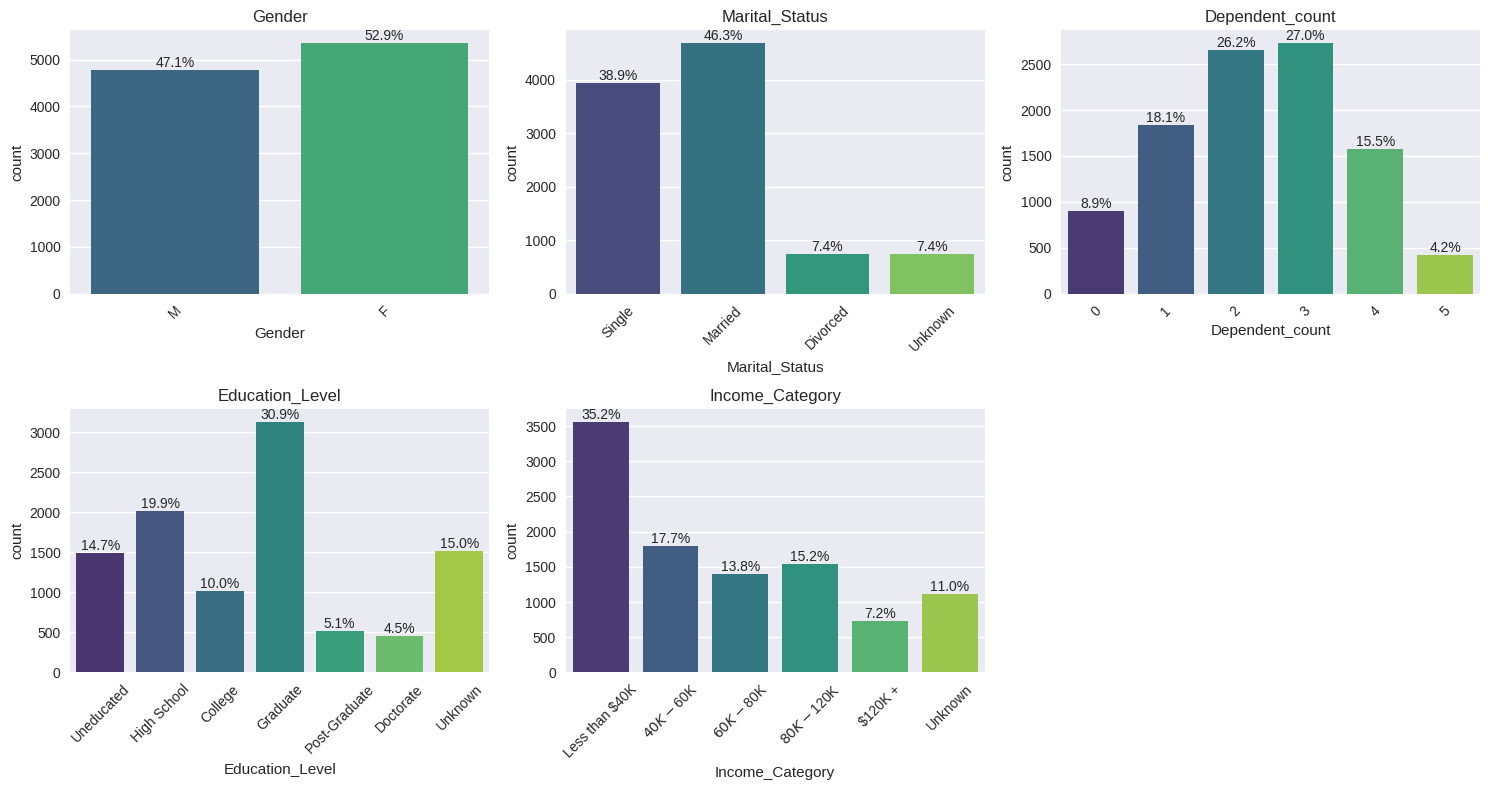

In [ ]:
# Customer demographic categorical fields
demographic_cols = ['Gender', 'Marital_Status', 'Dependent_count', 'Education_Level', 'Income_Category']

demographic_orders = {
  'Gender': ['M', 'F'],
  'Dependent_count': [0, 1, 2, 3, 4, 5],
  'Education_Level': ['Uneducated', 'High School', 'College', 'Graduate', 'Post-Graduate', 'Doctorate', 'Unknown'],
  'Income_Category': ['Less than $40K', '$40K - $60K', '$60K - $80K', '$80K - $120K', '$120K +', 'Unknown'],
  'Marital_Status': ['Single', 'Married', 'Divorced', 'Unknown']
}

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
axes = axes.flatten()

for i, col in enumerate(demographic_cols):
   sns.countplot(x=col, data=df, order=demographic_orders[col], ax=axes[i], palette='viridis') # Added palette
   axes[i].set_title(col)
   axes[i].tick_params(axis='x', rotation=45)

   # Add percentage labels on bars
   total = len(df[col])
   for p in axes[i].patches:
       percentage = f'{100 * p.get_height() / total:.1f}%'
       axes[i].annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='bottom', fontsize=10)

axes[-1].set_visible(False)

plt.tight_layout()
plt.savefig('demographic_distribution.png', dpi=600, bbox_inches='tight')
plt.show()

**Reasoning**:
Add code to save the bar plot figure for churn rate by demographic features after displaying the plot.



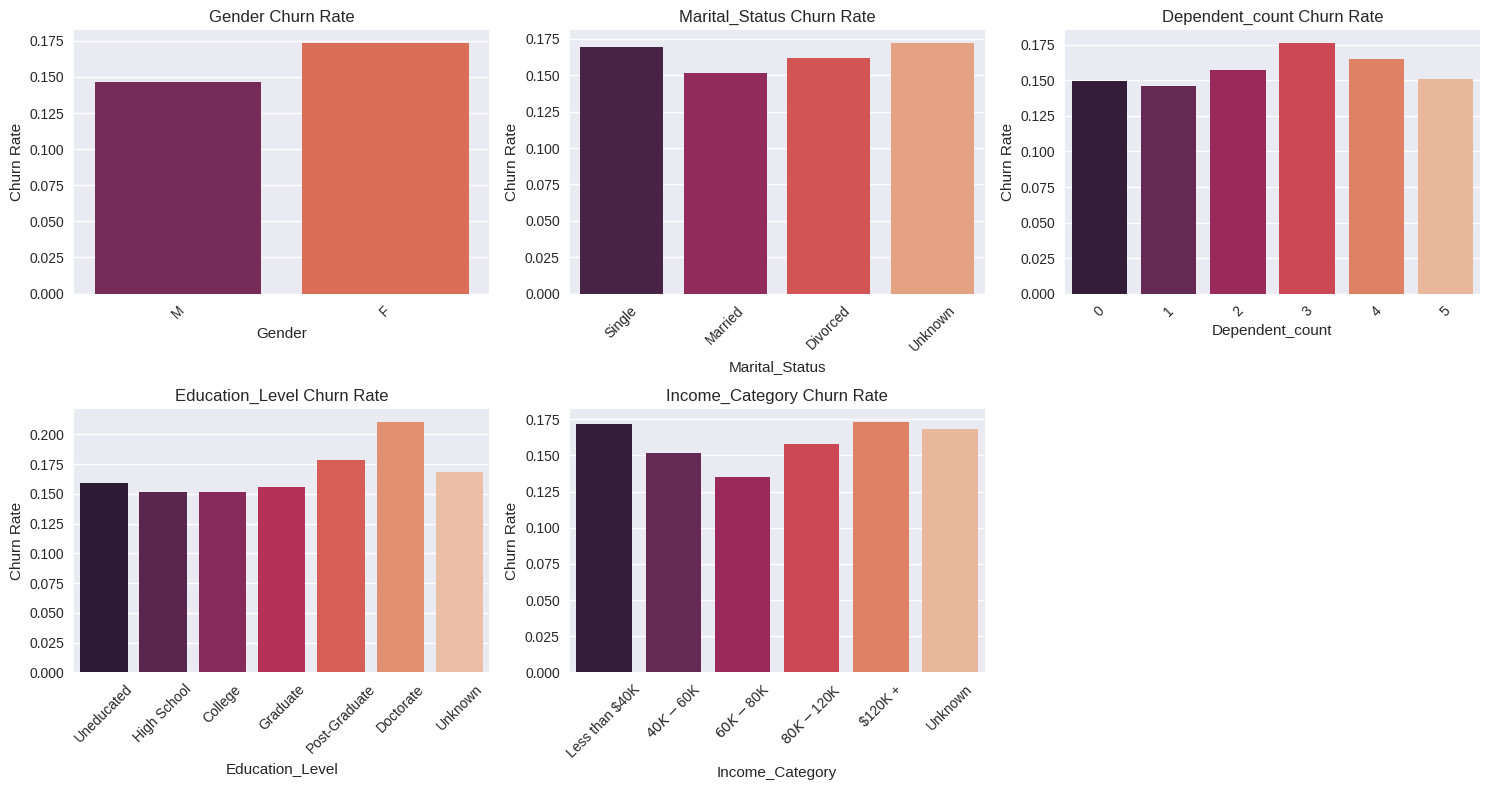

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
axes = axes.flatten()

for i, col in enumerate(demographic_cols):
    # Churn rate per category
    churn_rate = df.groupby(col)['Attrition_Flag'].apply(lambda x: (x=='Attrited Customer').mean())

    if demographic_orders[col]:
        churn_rate = churn_rate.reindex(demographic_orders[col])

    # Plot on the corresponding axis
    sns.barplot(x=churn_rate.index.astype(str), y=churn_rate.values, ax=axes[i], palette='rocket') # Changed to barplot and added palette
    axes[i].set_title(f'{col} Churn Rate')
    axes[i].set_ylabel('Churn Rate')
    axes[i].tick_params(axis='x', rotation=45)

axes[-1].set_visible(False)

plt.tight_layout()
plt.savefig('demographic_churn_rate.png', dpi=600, bbox_inches='tight')
plt.show()

**Reasoning**:
Add code to save the histogram figure for bank numerical features after displaying the plot.



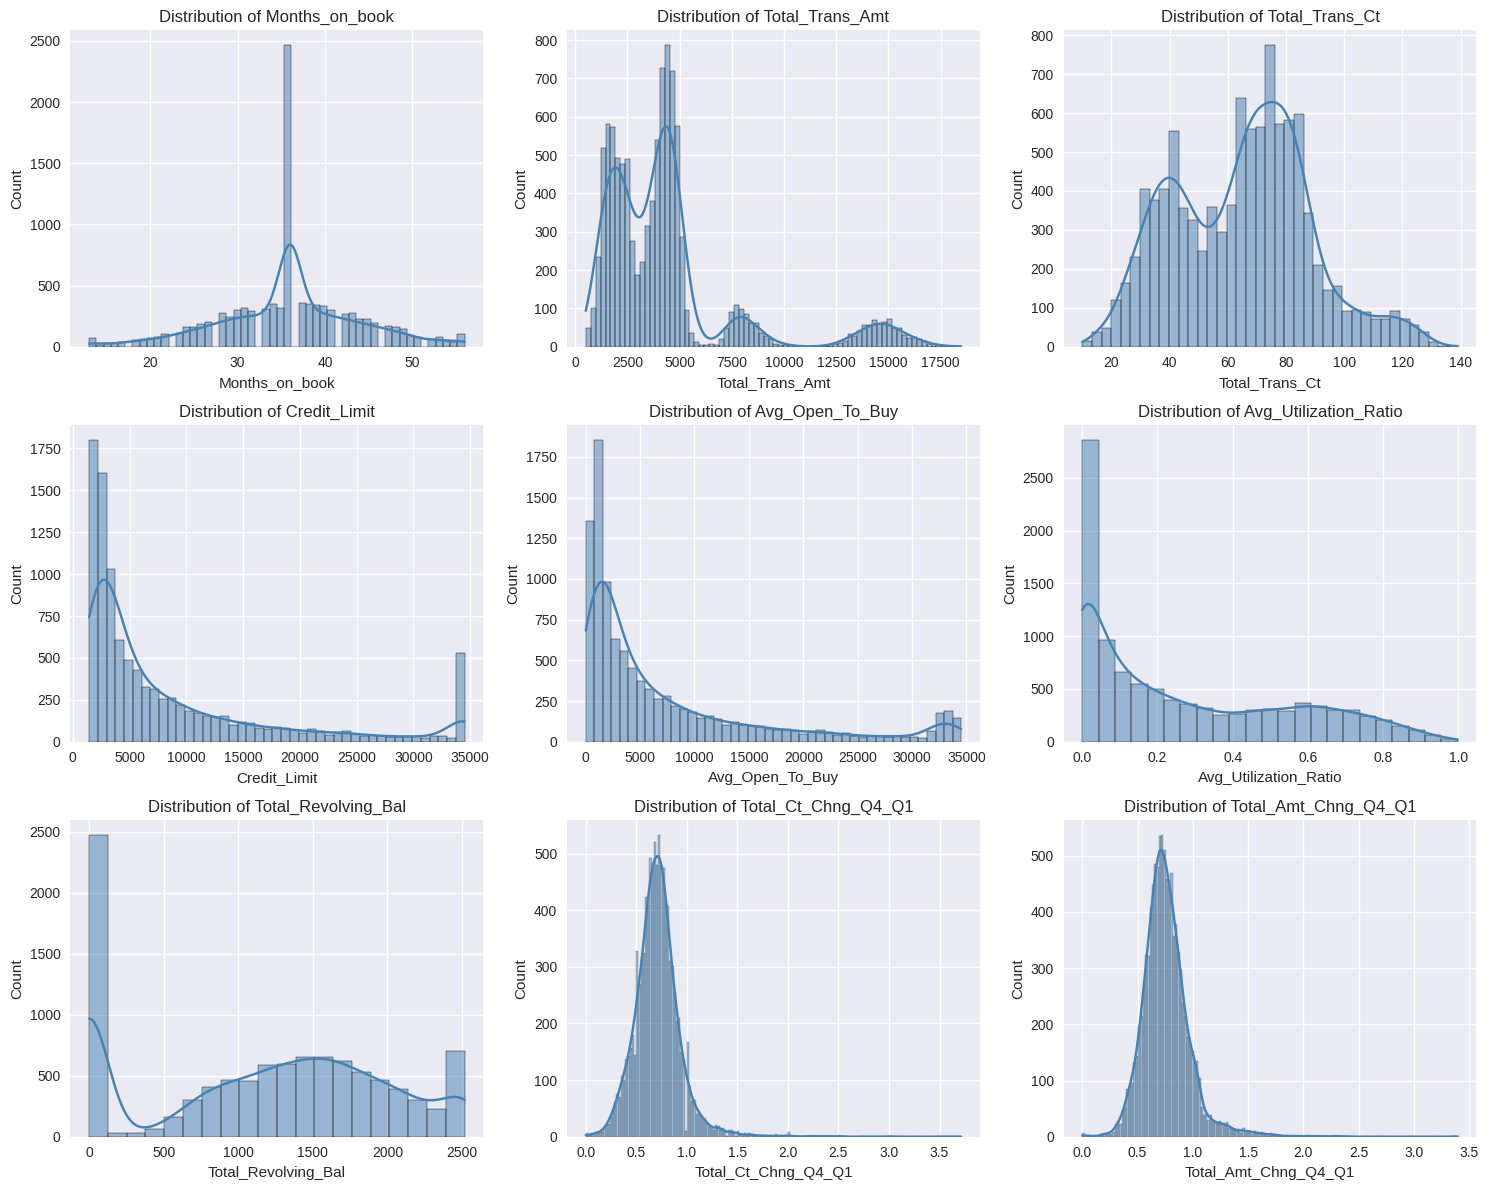

In [ ]:
# Bank numerical fields
bank_numerical_cols = [
   'Months_on_book', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Credit_Limit', 'Avg_Open_To_Buy', 'Avg_Utilization_Ratio','Total_Revolving_Bal', 'Total_Ct_Chng_Q4_Q1','Total_Amt_Chng_Q4_Q1',
]

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(bank_numerical_cols):
   sns.histplot(df[col], kde=True, ax=axes[i], color="steelblue") # Using a single color for consistency
   axes[i].set_title(f"Distribution of {col}")
   axes[i].set_xlabel(col)
   axes[i].set_ylabel("Count")

plt.tight_layout()
plt.savefig('bank_numerical_distribution.png', dpi=600, bbox_inches='tight')
plt.show()

**Reasoning**:
Add code to save the histogram figure for bank numerical features by attrition flag after displaying the plot.



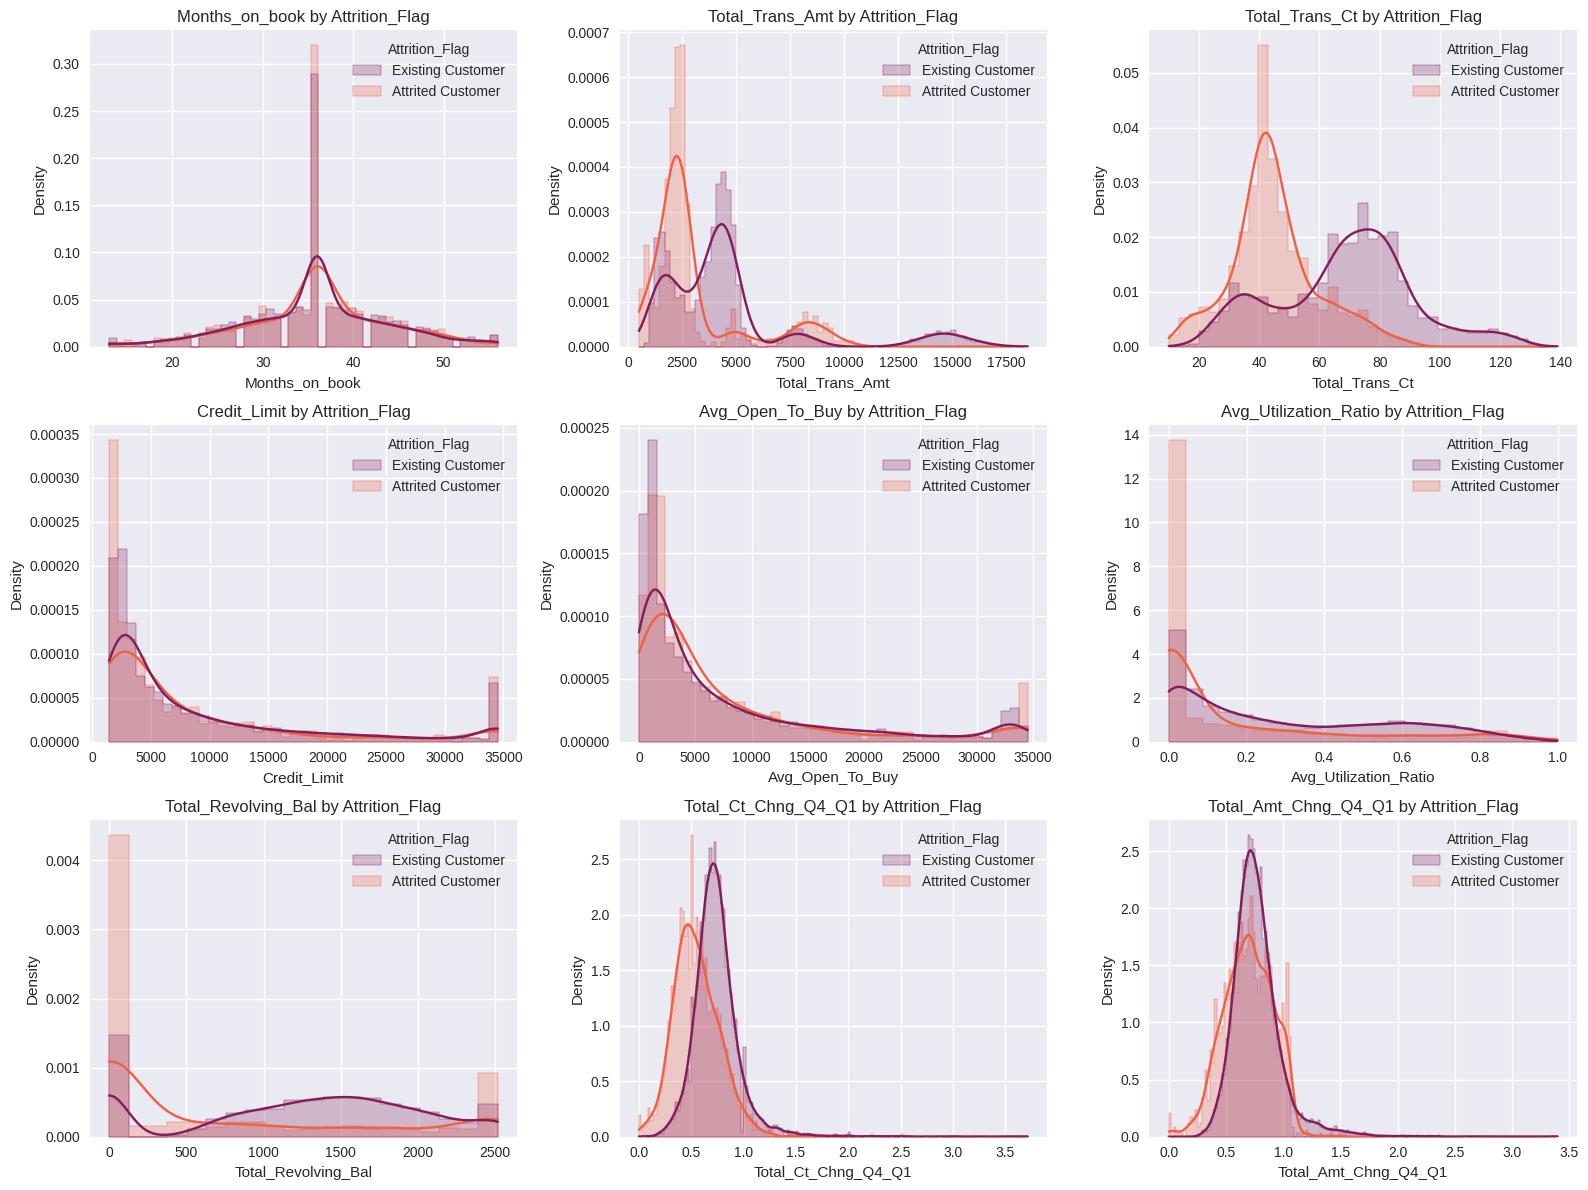

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(16, 12))
axes = axes.flatten()

for i, col in enumerate(bank_numerical_cols):
    sns.histplot(data=df, x=col, hue="Attrition_Flag", kde=True, ax=axes[i],
                 palette="rocket", element="step", stat="density", common_norm=False) # Changed palette
    axes[i].set_title(f"{col} by Attrition_Flag")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Density")

plt.tight_layout()
plt.savefig('bank_numerical_distribution_by_churn.png', dpi=600, bbox_inches='tight')
plt.show()

**Reasoning**:
Add code to save the countplot figure for bank categorical features after displaying the plot.



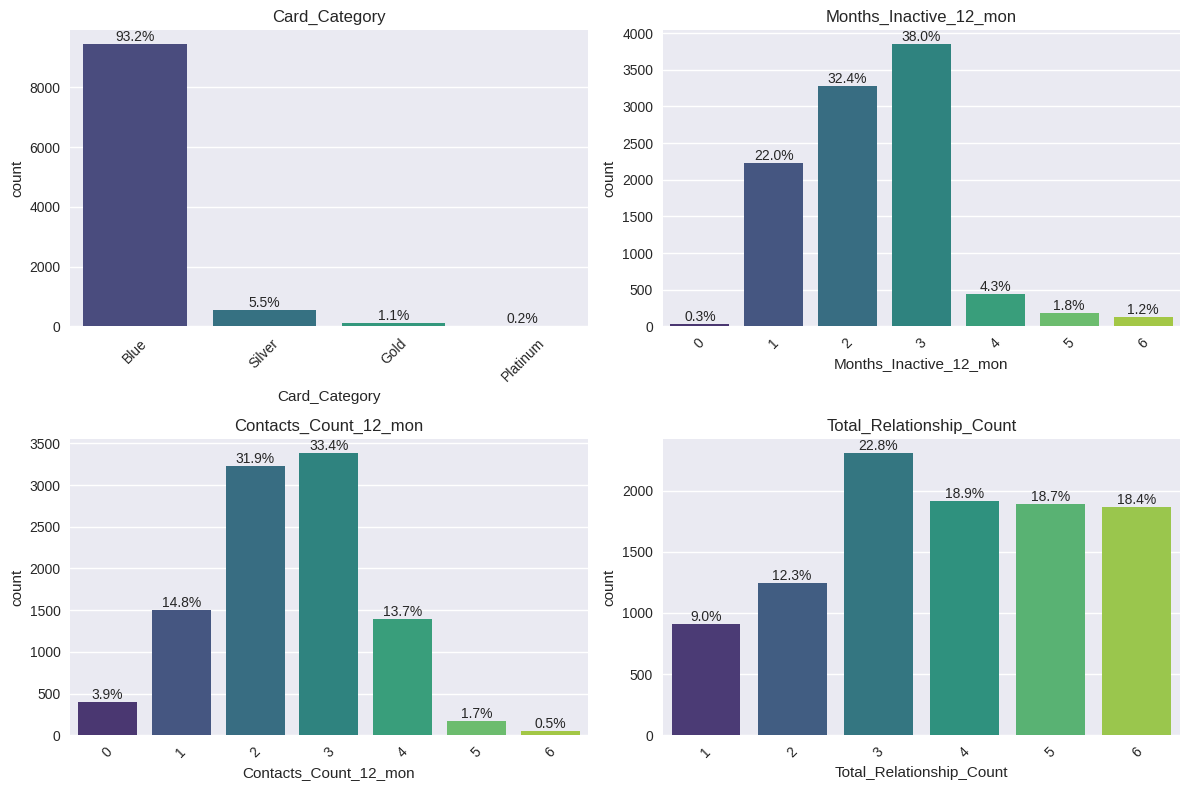

In [ ]:
# Bank account categorical/discrete fields
bank_categorical_cols = ['Card_Category', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Total_Relationship_Count']

bank_orders = {
 'Card_Category': ['Blue', 'Silver', 'Gold', 'Platinum'],
 'Months_Inactive_12_mon': None,
 'Contacts_Count_12_mon': None,
 'Total_Relationship_Count': None
}

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes = axes.flatten()

for i, col in enumerate(bank_categorical_cols):
   sns.countplot(x=col, data=df, order=bank_orders[col], ax=axes[i], palette='viridis') # Added palette
   axes[i].set_title(col)
   axes[i].tick_params(axis='x', rotation=45)

   # Add percentage labels on bars
   total = len(df[col])
   for p in axes[i].patches:
       percentage = f'{100 * p.get_height() / total:.1f}%'
       axes[i].annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('bank_categorical_distribution.png', dpi=600, bbox_inches='tight')
plt.show()

**Reasoning**:
Add code to save the bar plot figure for churn rate by bank categorical features after displaying the plot.



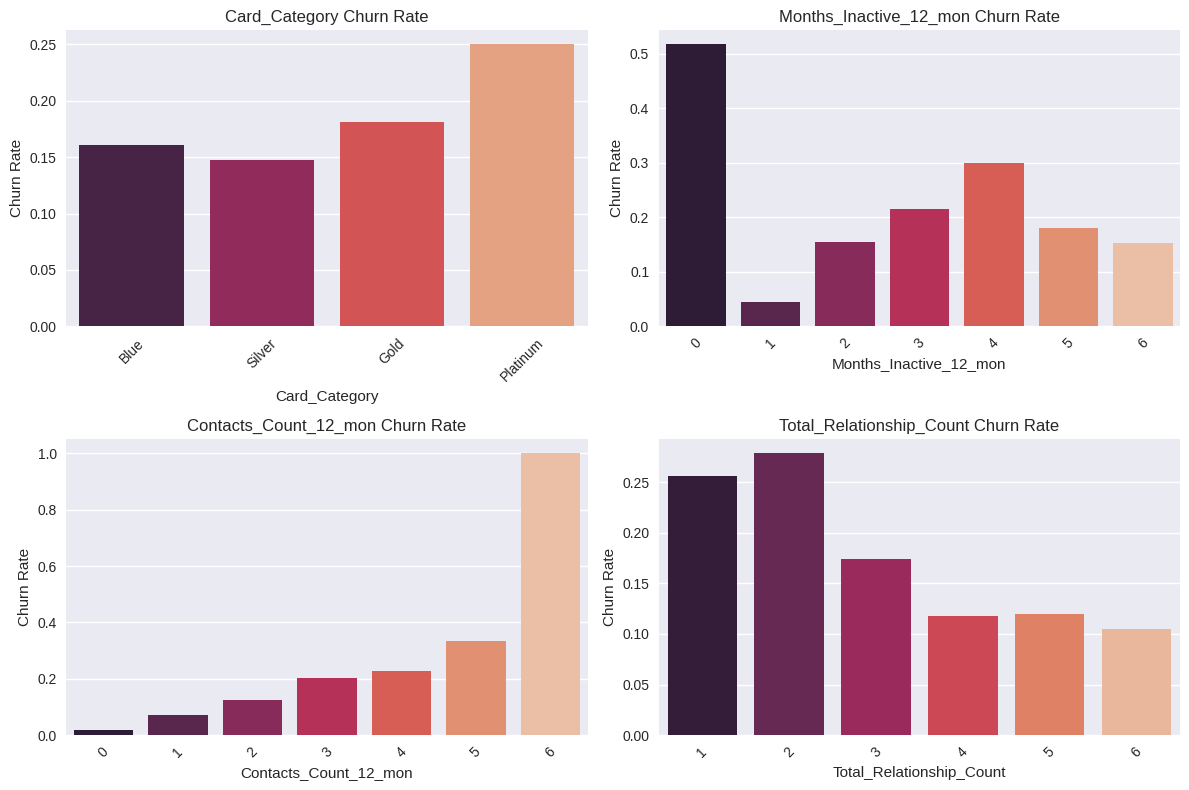

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes = axes.flatten()

for i, col in enumerate(bank_categorical_cols):
   # Compute churn rate per category
   churn_rate = df.groupby(col)['Attrition_Flag'].apply(lambda x: (x=='Attrited Customer').mean())

   if bank_orders[col]:
       churn_rate = churn_rate.reindex(bank_orders[col])

   # Plot on the corresponding axis
   sns.barplot(x=churn_rate.index.astype(str), y=churn_rate.values, ax=axes[i], palette='rocket') # Changed to barplot and added palette
   axes[i].set_title(f'{col} Churn Rate')
   axes[i].set_ylabel('Churn Rate')
   axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('bank_categorical_churn_rate.png', dpi=600, bbox_inches='tight')
plt.show()

**Reasoning**:
Add code to save the bar chart for the attrition flag distribution after displaying the plot.



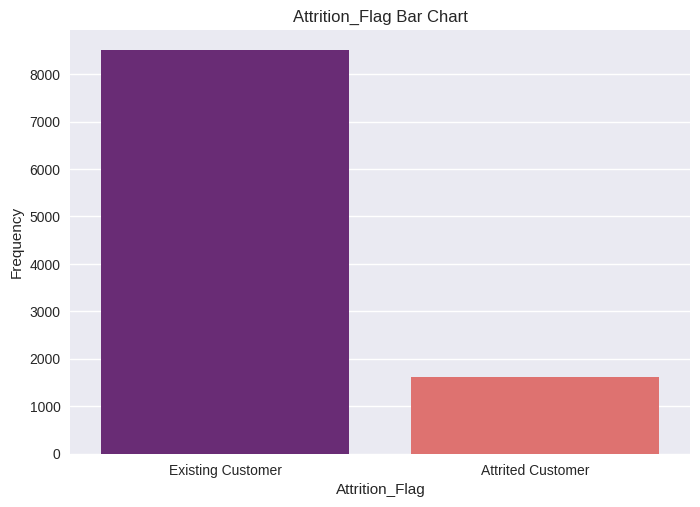

In [ ]:
# Bar chart for Attrition_Flag
sns.countplot(x='Attrition_Flag', data=df, palette='magma') # Added palette
plt.title('Attrition_Flag Bar Chart')
plt.xlabel('Attrition_Flag')
plt.ylabel('Frequency')
plt.savefig('attrition_flag_distribution.png', dpi=500, bbox_inches='tight')
plt.show()

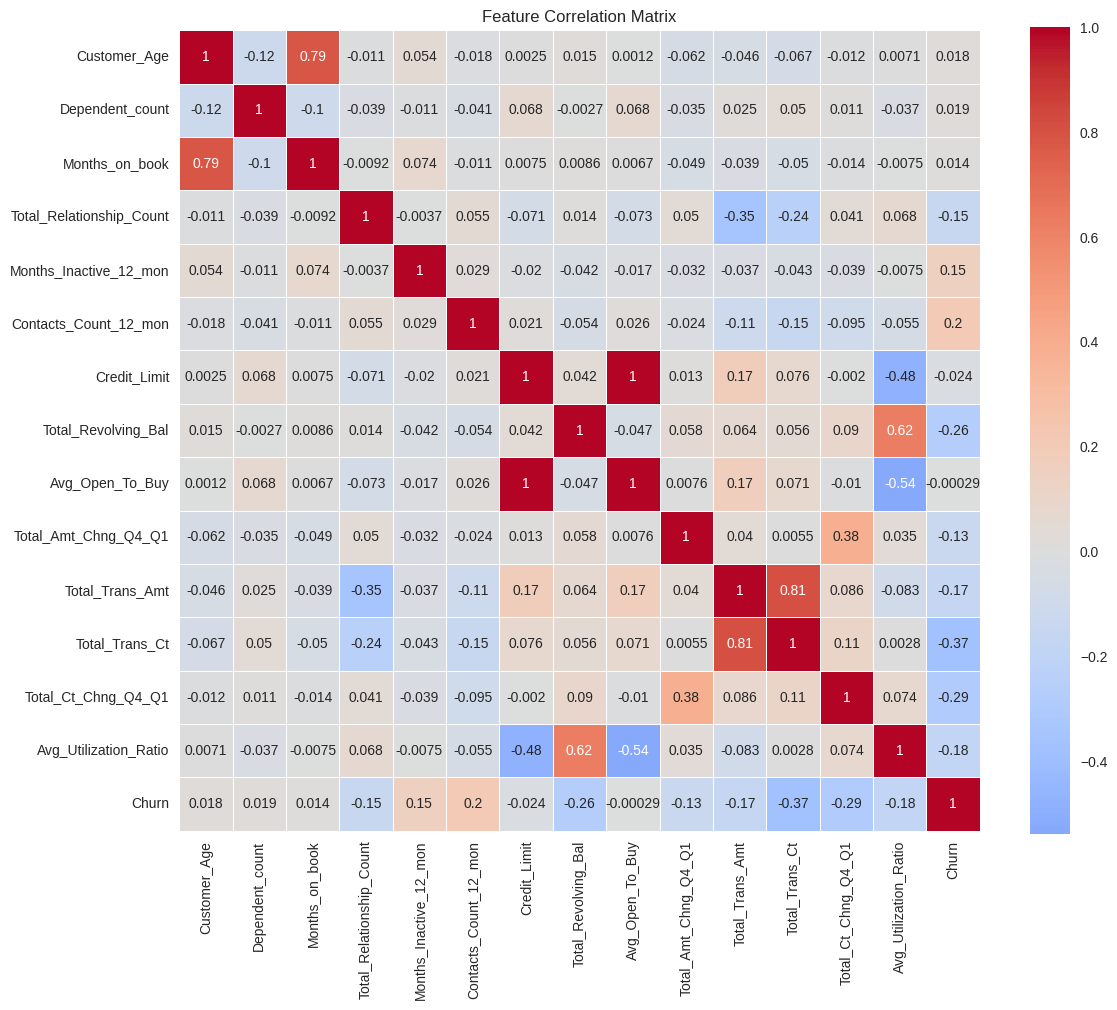

In [ ]:
# Correlation analysis for numerical features
numerical_features = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numerical_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.savefig('correlation.png', dpi=500, bbox_inches='tight')
plt.show()